In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import date
from pandas.api.types import is_string_dtype
from scipy.stats import skew, boxcox_normmax, shapiro
from scipy.special import boxcox1p, inv_boxcox1p
from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor, IsolationForest
from sklearn.pipeline import make_pipeline

In [177]:
boxcox_normmax(df.SalePrice+1)

0.35415355440141116

In [ ]:
df[df.GarageArea == 0].MSZoning.value_counts()

RL    50
Name: MSZoning, dtype: int64

<Axes: xlabel='GarageArea', ylabel='SalePrice'>

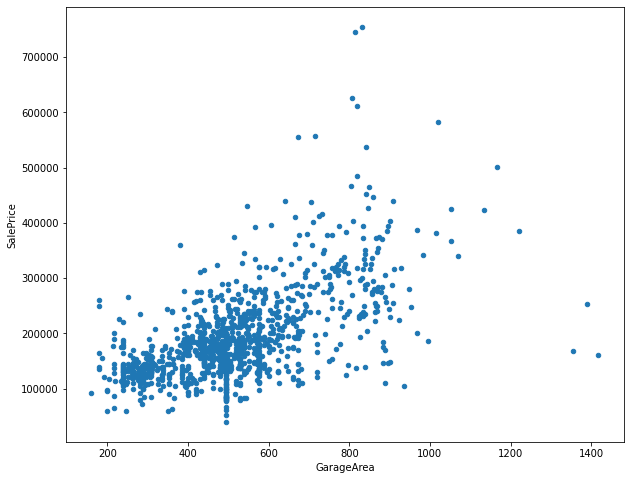

In [ ]:
# df[['GarageArea', 'SalePrice']].corr()
df.loc[df.GarageArea == 0, 'GarageArea'] = df.loc[df.GarageArea != 0, 'GarageArea'].median()
df[['GarageArea', 'SalePrice']].plot(figsize=(10, 8),kind='scatter', x='GarageArea', y='SalePrice')

In [ ]:
df.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

<Axes: >

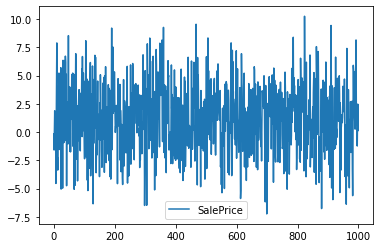

In [4]:
y = pd.DataFrame({'SalePrice': np.random.normal(1, 3, 1000)})
y.plot()

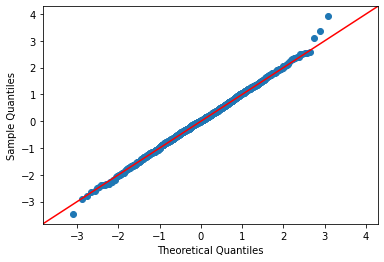

In [5]:
y = pd.Series(np.random.normal(0, 1, 1000))
_ = sm.qqplot(y, line='45')

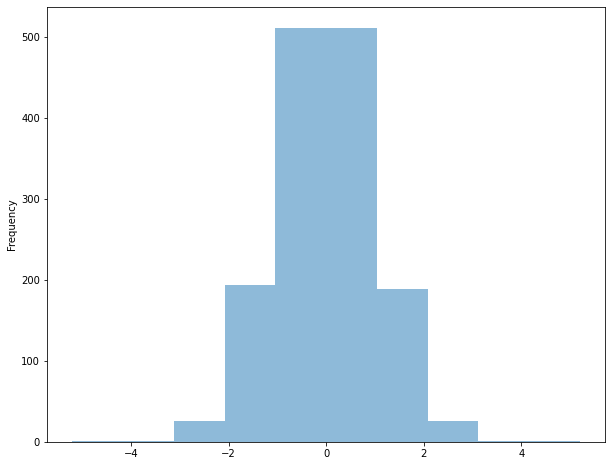

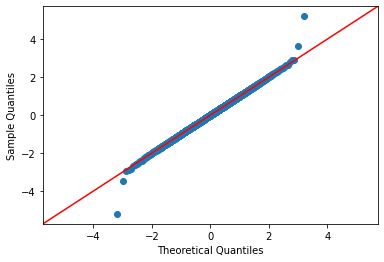

In [59]:
from sklearn.preprocessing import QuantileTransformer
df = pd.read_csv(f'{path}train.csv')

quantile_trans = QuantileTransformer(output_distribution='normal')
data_transformed = quantile_trans.fit_transform(df.SalePrice.to_numpy().reshape(-1, 1))
# df.SalePrice.to_numpy().reshape(-1, 1)
#
#
xs = pd.Series(data_transformed.flatten())
xs.plot(kind='hist', figsize=(10, 8), alpha=.5)

_ = sm.qqplot(xs, line='45')

0.9230407476425171 1.1186357325569005e-26
P-value is 0.0000


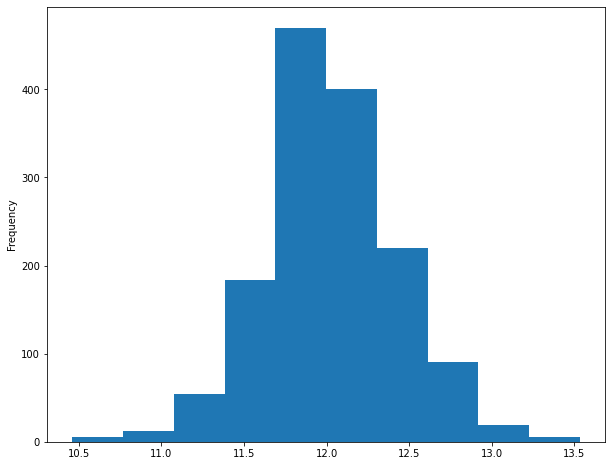

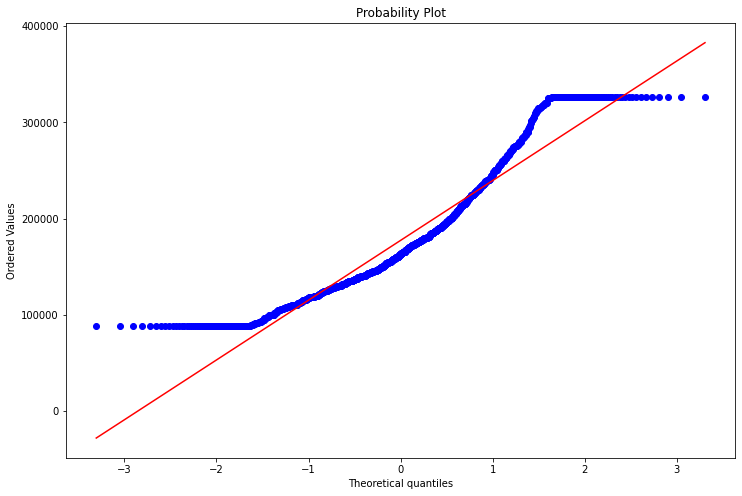

In [2]:
# Simple alternative
from scipy.stats import shapiro
from scipy.special import boxcox1p, inv_boxcox1p
path = '/Users/jking/kaggle/house-prices-advanced-regression-techniques/'
df = pd.read_csv(f'{path}train.csv')
tf = pd.read_csv(f'{path}test.csv')

# y = pd.Series(np.random.normal(1, 1, 1000))
# y = df.SalePrice.clip(lower=df.SalePrice.quantile(0.01), upper=df.SalePrice.quantile(0.99))
# y = df.SalePrice
y = np.log1p(df.SalePrice)
# y = boxcox1p(y, .99)

y.plot(kind='hist', figsize=(10, 8))
y = df.SalePrice.clip(lower=df.SalePrice.quantile(0.05), upper=df.SalePrice.quantile(0.95))

t, p = shapiro(y)
print(t, p)
print(f'P-value is {p:.4f}')  # if less than .05 we reject the NULL and accept that it's not normal

from scipy import stats
_, ax = plt.subplots(1, 1, figsize = (12 , 8))
_ = stats.probplot(y, plot=ax)

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,DaysSinceSold,XX1,XX2,XX3,XX4,XX5,XX6,XX7,XX8,XX9
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,17.673458,27.011647,40.0,5.138794,4.411466,10960.0,21,10.896708,56,21
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,17.849251,31.490145,94.0,4.863716,4.700151,21620.0,12,11.260318,36,18
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,17.532699,28.023935,44.0,5.150834,4.467217,13376.0,21,11.008279,42,21
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,18.123746,47.657018,75.0,5.139927,5.105383,16050.0,14,11.075941,49,21
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,17.471120,32.574035,69.0,5.375208,4.542724,19228.0,24,11.559284,72,32


In [200]:
xs.loc[c]

2.6748646898037354

In [206]:
# df.select_dtype
df.dtypes.value_counts()

numerical_cols = df.select_dtypes('float64').columns.to_list() + df.select_dtypes('int64').columns.to_list()
xs = df[numerical_cols].fillna(0).apply(lambda xs: abs(skew(xs)))
for c in xs[xs > .5].index.to_list():
    print(f'Normalizing skew {xs.loc[c]:.2f} for feature {c} using boxcox transformation')
    df[c] = boxcox1p(df[c], boxcox_normmax(df[c].fillna(0) + 1))    # TODO: remove fill na with zero when value imputation is added

Normalizing skew 2.67 for feature MasVnrArea using boxcox transformation
Normalizing skew 3.87 for feature GarageYrBlt using boxcox transformation
Normalizing skew 1.41 for feature MSSubClass using boxcox transformation
Normalizing skew 12.20 for feature LotArea using boxcox transformation
Normalizing skew 0.69 for feature OverallCond using boxcox transformation
Normalizing skew 0.61 for feature YearBuilt using boxcox transformation
Normalizing skew 0.50 for feature YearRemodAdd using boxcox transformation
Normalizing skew 1.68 for feature BsmtFinSF1 using boxcox transformation
Normalizing skew 4.25 for feature BsmtFinSF2 using boxcox transformation
Normalizing skew 0.92 for feature BsmtUnfSF using boxcox transformation
Normalizing skew 1.52 for feature TotalBsmtSF using boxcox transformation
Normalizing skew 1.38 for feature 1stFlrSF using boxcox transformation
Normalizing skew 0.81 for feature 2ndFlrSF using boxcox transformation
Normalizing skew 9.00 for feature LowQualFinSF using b

/Users/jking/miniforge3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/jking/miniforge3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


Normalizing skew 0.68 for feature TotRmsAbvGrd using boxcox transformation
Normalizing skew 0.65 for feature Fireplaces using boxcox transformation
Normalizing skew 1.54 for feature WoodDeckSF using boxcox transformation
Normalizing skew 2.36 for feature OpenPorchSF using boxcox transformation
Normalizing skew 3.09 for feature EnclosedPorch using boxcox transformation
Normalizing skew 10.29 for feature 3SsnPorch using boxcox transformation
Normalizing skew 4.12 for feature ScreenPorch using boxcox transformation
Normalizing skew 14.81 for feature PoolArea using boxcox transformation
Normalizing skew 24.45 for feature MiscVal using boxcox transformation


In [404]:
# KNNImputer(missing_values=np.nan, n_neighbors=4).fit_transform(df[features])
df['MSZoning'] = OrdinalEncoder().fit_transform(df['MSZoning'])
df['MSZoning']

ValueError: Expected 2D array, got 1D array instead:
array=['RL' 'RL' 'RL' ... 'RL' 'RL' 'RL'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [511]:
cols =df.columns.to_list()

for c in cols:
    if 'Exposure' in c:
        print(c)

BsmtExposure


In [464]:
xs = df.ExterCond
print(xs.unique())

qual_order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
xs2 = OrdinalEncoder(categories=[qual_order]).fit_transform(df[['ExterCond']])
# xs2 = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']]).fit_transform(df.loc[:, ['ExterCond']])
# xs2 = OrdinalEncoder().fit_transform(df.loc[:, ['ExterCond']])
# xs2 = OrdinalEncoder().fit_transform(df.ExterCond)
xs2
pd.DataFrame({'Orig': xs, 'Enc': xs2.flatten()}).drop_duplicates()

['TA' 'Gd' 'Fa' 'Po' 'Ex']


,Orig,Enc
0,TA,2.0
24,Gd,3.0
30,Fa,1.0
250,Po,0.0
508,Ex,4.0


In [510]:
df.PoolQC.value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [7]:
def rmse(actual, y_pred, **kwargs) -> float:
    # Use MSE since y is already in log space
    return np.sqrt(mean_squared_error(actual, y_pred))

In [40]:

#############################################
# Simple alternative
path = '/Users/jking/kaggle/house-prices-advanced-regression-techniques/'
df = pd.read_csv(f'{path}train.csv')
tf = pd.read_csv(f'{path}test.csv')

df[['OverallQual', 'SalePrice']].corr()

# df = df[df.MSZoning == 'C (all)']

from scipy.special import boxcox1p, inv_boxcox1p
# df.SalePrice = boxcox1p(df.SalePrice, .15)
df.SalePrice = np.log1p(df.SalePrice)
# I haven't tried submitting this yet
# df.SalePrice = df.SalePrice.clip(lower=df.SalePrice.quantile(0.05), upper=df.SalePrice.quantile(0.95))
lmbda  = .05
# df.SalePrice = boxcox1p(df.SalePrice, lmbda)

features = ['MSZoning',
            #'MSSubClass',
            #'Exterior1st',
            # 'Exterior2nd',
            #'LotConfig',
            'OverallQual',
            # 'OverallCond',
            'YearsOld',
            'MoSold',  # Seasonality impact?
            'YearRemodAdd',
            'TotalSqf', 
            'GrLivArea', 
            'TotalBsmtSF',
            '1stFlrSF',
            '2ndFlrSF',
            'LotArea', 
            'LotFrontage',
            #'ExterCond', 
            'BedroomAbvGr',
            'AllBathrooms', 
            'AllHalfBathrooms',
            'TotRmsAbvGrd',
            #'GarageType', 
            'GarageCars', 
            'GarageArea', 
            'GarageYearsOld',
            'PavedDrive', 
            # 'GarageCond', 
            #'GarageFinish',
            'Fence',
            #'SaleCondition',
            'YearsSoldAgo',
            'DaysSinceSold',
            'WoodDeckSF', 
            'OpenPorchSF',
            'EnclosedPorch',
            #'Fireplaces',
            #'KitchenAbvGr',
            'CentralAir',
            #'BsmtExposure',
            # 'MasVnrArea', 'MasVnrType', 'MiscFeature',
            'XX1', 'XX2', 'XX3','XX4', 'XX5', 'XX6', 'XX7', 'XX8', 'XX9',
            # 'LandContour', 'Utilities', 
            #'HouseStyle'
]

features = df.drop(columns=['Id', 'SalePrice']).columns.to_list()

# These are the good features for TF model?
#features = ['MSZoning', 'OverallQual', 'YearsOld', 'TotalSqf', 'LotArea', 'ExterCond', 
#            'Alley', 'XX1', 'XX3', 'Electrical', 'Exterior1st', 'Exterior2nd', 
#            'CentralAir', 'Condition1']


def process_data(df, features, verbose=False):
    df = df.copy(deep=True)
    
    #df['OverallQual'] = QuantileTransformer(output_distribution='normal').fit_transform(
    #    df.OverallQual.to_numpy().reshape(-1, 1))
    
    # Features
    df['YearsOld'] = date.today().year - df.YearBuilt
    df['TotalSqf'] = df['1stFlrSF'] + df['2ndFlrSF']
    df['AllBathrooms'] = df.FullBath + df.BsmtFullBath
    df['AllHalfBathrooms'] = df.HalfBath + df.BsmtHalfBath

    df['GarageYearsOld'] = (date.today().year - df.GarageYrBlt)
    df['YearsSoldAgo'] = (date.today().year - df.YrSold)
    df['DaysSinceSold'] = df.apply(lambda xs: pd.date_range(start=date(xs.YrSold, xs.MoSold, 1), 
                                                            end=date.today()).shape[0], axis=1)

    df['XX1'] = df['OverallQual'].mul(df.YearsOld)
    df['XX2'] = df['GarageCars'].mul(df.GarageYearsOld)
    df['XX3'] = df['OverallQual'].mul(df.TotalSqf)
    df['XX4'] = df['TotalSqf'].mul(df.YearsOld)
    df['XX5'] = df['GarageArea'].mul(df.GarageYearsOld)
    df['XX6'] = df['AllBathrooms'].mul(df.OverallQual)
    df['XX7'] = df['1stFlrSF'].mul(df.OverallQual)
    df['XX8'] = df['TotRmsAbvGrd'].mul(df.OverallQual)
    df['XX9'] = df['BedroomAbvGr'].mul(df.OverallQual)

    df['YY1'] = df['OverallQual'].pow(df.TotalSqf)

    numerical_cols = df.select_dtypes('float64').columns.to_list() + df.select_dtypes('int64').columns.to_list()
    xs = df[numerical_cols].fillna(0).apply(lambda xs: abs(skew(xs)))
    for c in xs[xs > .5].index.to_list():
        if df[c].min() <= -.9:
            df[c] = np.log1p(df[c])
        if verbose:
            print(f'Normalizing skew {xs.loc[c]:.2f} for feature {c} using boxcox transformation')
        df[c] = boxcox1p(df[c], boxcox_normmax(df[c].replace([-np.inf, np.inf], 0).fillna(0) + 1))    # TODO: remove fill na with zero when value imputation is added

    for c in df.select_dtypes('float64').columns.to_list():
        df[c] = np.log1p(df[c])

    # df.loc[df.GarageArea == 0, 'GarageArea'] = df.loc[df.GarageArea != 0, 'GarageArea'].median()
    ###############
    # Encode ordinal-based categorical columns
    qual_order = ['Po', 'Fa', 'Na', 'TA', 'Gd', 'Ex']
    for c in ['ExterCond', 'KitchenQual', 'BsmtQual', 'GarageQual', 'HeatingQC', 'PoolQC']:
        df[[c]] = OrdinalEncoder(categories=[qual_order]).fit_transform(df[[c]].fillna('Na'))
    exp_order = ['No', 'Mn', 'Na', 'Av', 'Gd']
    for c in ['BsmtExposure']:
        df[[c]] = OrdinalEncoder(categories=[exp_order]).fit_transform(df[[c]].fillna('Na'))    
    
    # Filter to only requested features
    df = df[features]
    
    ###############
    # Encode any features leftover of string type using OHE
    for c, t in df.dtypes.items():
        if is_string_dtype(t):
            #if df[c].value_counts().shape[0] == 2:
            #    if verbose:
            #        print(f'Encoding {c} using Binary OHE')
            #    df = df.drop(columns=c).join(pd.get_dummies(df[c], drop_first=True))
            #else:
            if verbose:
                print(f'Encoding {c} using OHE')
            df = df.join(pd.get_dummies(df[c], prefix=c)).drop(columns=c)

    return df.loc[:, ~df.columns.duplicated()]

ff = process_data(df=df, features=features, verbose=False)

X = KNNImputer(missing_values=np.nan, n_neighbors=4).fit_transform(ff)
X = RobustScaler().fit_transform(X)
y = df.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
#### _train, X_test, y_train, y_test = (X, X, y, y)

def rmse(actual, y_pred, **kwargs) -> float:
    # Use MSE since y is already in log space
    return np.sqrt(mean_squared_error(actual, y_pred))


model_xgb = xgb.XGBRegressor(# n_estimators=8000,
                             n_estimators=10000,
                             learning_rate=.001,  # Good
                             max_depth=10,
                             subsample=.45,
                             objective='reg:squarederror',
                             eval_metric=rmse,
                             # early_stopping_rounds=20,

)
feature_cols = ff.columns
# model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

def cv_rmse(model, X, y, cv):
    res = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=cv))
    # res = np.sqrt(-cross_val_score(model,X, y, scoring=make_scorer(rmse, greater_is_better=False), cv=kf))
    ### ! res = cross_val_score(model,X, y, scoring=make_scorer(rmse), cv=cv)
    # res = np.sqrt(cross_val_score(model,X, y, scoring="mean_squared_error", cv=cv))
    return res
# res = cv_rmse(model_xgb, X_train, y_train)
# print(f'Average KFold cross validation score: {res.mean()}')

"""
model = make_pipeline(KNNImputer(missing_values=np.nan, n_neighbors=8),
                      StandardScaler(),
                      SVR(C=.5, epsilon=0.001, gamma=.0009),
                      verbose=True)
model.fit(X_train, y_train)
y_pred_x = model.predict(X_test)
print('SVR Regression')
print(round(rmse(y_test, y_pred_x), 4))
######################################################################

pipe = make_pipeline(KNNImputer(missing_values=np.nan, n_neighbors=8),
                      StandardScaler(), 
                      verbose=True)
model = SVR(C=.5, epsilon=0.001, gamma=.0009)
model.fit(pipe.fit_transform(X_train), y_train)
y_pred_x = model.predict(pipe.transform(X_test))
print('SVR Regression')
print(round(rmse(y_test, y_pred_x), 4))
"""

# XGB ##############
# best without CV was .1251
kf = KFold(n_splits=10, random_state=42, shuffle=True)
score = cv_rmse(model_xgb, X=X, y=y, cv=kf)
print('-----')
print('XGB Regression')
print(round(score.mean(), 2))
#model_xgb.fit(X_train, y_train)# , eval_set=[(X_test, y_test)])
# y_pred1 = model_xgb.predict(X_test)
#print(round(rmse(y_test, y_pred1), 4))

model_lgb = lgb.LGBMRegressor(n_estimators=8000,
                             learning_rate=.05,
                             max_depth=5,)
model_lgb.fit(X_train, y_train)
y_pred_xx = model_lgb.predict(X_test)
print('LGB Regression')
print(round(rmse(y_test, y_pred_xx), 4))

model_ridge = Ridge(max_iter=3000, alpha=.05)
model_ridge.fit(X_train, y_train)
y_pred2 = model_ridge.predict(X_test)
print('Ridge Regression')
print(round(rmse(y_test, y_pred2), 4))

# ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
# from sklearn.linear_model import RidgeCV
# ridge = make_pipeline(SimpleImputer(), RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))
ridge = make_pipeline(SimpleImputer(), RobustScaler(), Ridge(alpha=15.))

print('Ridge Regressor2')
score = cv_rmse(ridge, X=X, y=y, cv=kf)
print(round(score.mean(), 4))
# y_pred2 = ridge.predict(X_test)
#ridge.fit(X_train, y_train)
#y_pred_x = ridge.predict(X_test)
#print(round(rmse(y_test, y_pred_x), 4))


model_lasso = Lasso(max_iter=3000, alpha=.0025)
score = cv_rmse(model_lasso, X, y, cv=kf)
#model_lasso.fit(X_train, y_train)
# y_pred3 = model_lasso.predict(X_test)
print('Lasso Regression')
print(round(score.mean(), 4))
# print(round(rmse(y_test, y_pred3), 4))

model_rf = RandomForestRegressor(n_estimators=3000, max_depth=10)
model_rf.fit(X_train, y_train)
y_pred4 = model_rf.predict(X_test)
print('RF Regression')
print(round(rmse(y_test, y_pred4), 4))

print('TF Regression')
y_pred5 = y_pred1
print(round(rmse(y_test, y_pred5), 4))

preprocess = make_pipeline(KNNImputer(missing_values=np.nan, n_neighbors=2),
                           StandardScaler())
model_srv = SVR(C=1.1, epsilon= 0.005, gamma=.0005)
model_srv.fit(preprocess.fit_transform(X_train), y_train)
score = cv_rmse(model_lasso, X, y, cv=kf)
y_pred6 = model_srv.predict(X_test)
print('SVR Regression')
print(round(score.mean(), 4))
# print(round(rmse(y_test, y_pred6), 4))

y_pred = (.2 * y_pred1) + (.1 * y_pred2) + (.1 * y_pred3) + (.2 * y_pred4) + (.1 * y_pred5) + (.3 * y_pred6)

#cv = KFold(n_splits=5, shuffle=True)
#model_mlp = MLPRegressor(activation='relu', alpha=.05, learning_rate='adaptive', solver='adam')
#model_svm = SVR()
#model_lasso = Lasso()
#model_adaboost = AdaBoostRegressor(n_estimators=5000, learning_rate=.05)
#model_rf = RandomForestRegressor(n_estimators=8000)

#estimators = [('rf', model_rf), ('svm', model_svm), ('ada', model_adaboost),  ('xgb', model_xgb)]
#model = StackingRegressor(estimators=estimators, cv=cv)
#model.fit(X, y)  # make this training only!
#y_pred = model.predict(X)

print('XXXXXXX')
print(round(rmse(y_test, y_pred), 4))
print(round(rmse(y_test.apply(np.expm1), np.floor(np.expm1(y_pred))), 4))

/Users/jking/miniforge3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/jking/miniforge3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


-----
XGB Regression
0.12
LGB Regression
0.1275
Ridge Regression
0.1789
Ridge Regressor2
0.126
Lasso Regression
0.1319
RF Regression
0.1373
TF Regression
0.1251
SVR Regression
0.1319
XXXXXXX
0.1349
35901.9941


In [ ]:
ridge['ridgecv'].alpha_

15.0

ValueError: x and y must be the same size

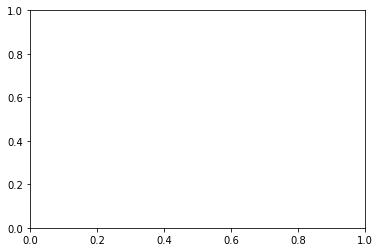

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Assuming you have your input data X and corresponding target data y

# Create the K-fold cross-validation object
kf = KFold(n_splits=10)

# Initialize the figure
fig, ax = plt.subplots()

# Loop over the folds and plot the data points with different colors for each fold
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
 
    # print(fold)
    # print(train_index, val_index)
    # kdf = pd.DataFrame(index=[fold], data={'Train': train_index, 'Validation': val_index})
    # print(kdf)
    # Plot training data in blue
    ax.scatter(X_train, y_train, color='blue', label='Training Data (Fold {})'.format(fold+1))
    
    # Plot validation data in red
    ax.scatter(X_val, y_val, color='red', label='Validation Data (Fold {})'.format(fold+1))

# Add legend and labels
#ax.legend()
#ax.set_xlabel('X')
#ax.set_ylabel('y')
#ax.set_title('Data with Cross-Validation Splits')

# Show the plot
#plt.show()

In [10]:
model_lgb = lgb.LGBMRegressor(n_estimators=8000,
                             learning_rate=.05,
                             max_depth=5,
)
                             # max_depth=10,)
                             #subsample=.45,
                             #objective='reg:squarederror',
                             #eval_metric=rmse,
model_lgb.fit(X_train, y_train)
y_pred_xx = model_lgb.predict(X_test)
print('LGB Regression')
print(round(rmse(y_test, y_pred_xx), 4))
# .1248 

LGB Regression
0.027


In [524]:
rmse(y_test, y_pred5)

0.5320599351748452

In [157]:
path = '/Users/jking/kaggle/house-prices-advanced-regression-techniques/'
df = pd.read_csv(f'{path}train.csv')
xs = df.isna().all(axis=0)
xs[xs == True]

Series([], dtype: bool)

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def process_data(df, features, verbose=False):
    df = df.copy(deep=True)
    
    #df['OverallQual'] = QuantileTransformer(output_distribution='normal').fit_transform(
    #    df.OverallQual.to_numpy().reshape(-1, 1))
    
    # Features
    df['YearsOld'] = date.today().year - df.YearBuilt
    # df.ExterCond = df.ExterCond.map({'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2})
    # df.SalePrice = boxcox1p(df.SalePrice, .15)
    df['TotalSqf'] = df['1stFlrSF'] + df['2ndFlrSF']
    df['AllBathrooms'] = df.FullBath + df.BsmtFullBath
    df['AllHalfBathrooms'] = df.HalfBath + df.BsmtHalfBath

    df['GarageYearsOld'] = (date.today().year - df.GarageYrBlt)
    df['YearsSoldAgo'] = (date.today().year - df.YrSold)
    df['DaysSinceSold'] = df.apply(lambda xs: pd.date_range(start=date(xs.YrSold, xs.MoSold, 1), 
                                                            end=date.today()).shape[0], axis=1)
    # df['PavedDrive'] = df.PavedDrive.map({'Y': 1, 'P': 0, 'N': -1})
    # df.LowQualFinSF = df.LowQualFinSF.mul(-1)
    #df['CentralAir'] = df.CentralAir.map({'Y': 1, 'N': -1})
    #df.HeatingQC = df.HeatingQC.map({'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2})
    #df.BsmtExposure = df.BsmtExposure.map({'Gd': 1, 'Av': 0, 'Mn': -1, 'No': -2, 'NA': 0})
    #df.KitchenQual = df.KitchenQual.map({'Ex': 2, 'Gd': 1, 'TA': 0, 'FA': -1, 'Po': -2})

    df['XX1'] = df['OverallQual'].mul(df.YearsOld)
    df['XX2'] = df['GarageCars'].mul(df.GarageYearsOld)
    df['XX3'] = df['OverallQual'].mul(df.TotalSqf)
    df['XX4'] = df['TotalSqf'].mul(df.YearsOld)
    df['XX5'] = df['GarageArea'].mul(df.GarageYearsOld)
    df['XX6'] = df['AllBathrooms'].mul(df.OverallQual)
    df['XX7'] = df['1stFlrSF'].mul(df.OverallQual)
    df['XX8'] = df['TotRmsAbvGrd'].mul(df.OverallQual)
    df['XX9'] = df['BedroomAbvGr'].mul(df.OverallQual)

    numerical_cols = df.select_dtypes('float64').columns.to_list() + df.select_dtypes('int64').columns.to_list()
    xs = df[numerical_cols].fillna(0).apply(lambda xs: abs(skew(xs)))
    for c in xs[xs > .5].index.to_list():
        df[c] = np.log1p(df[c])
        #if df[c].min() <= -.9:
        #    df[c] = np.log1p(df[c]) 
        #print(f'Normalizing skew {xs.loc[c]:.2f} for feature {c} using boxcox transformation')
        #df[c] = boxcox1p(df[c], boxcox_normmax(df[c].replace([-np.inf, np.inf], 0).fillna(0) + 1))    # TODO: remove fill na with zero when value imputation is added

    # df.loc[df.GarageArea == 0, 'GarageArea'] = df.loc[df.GarageArea != 0, 'GarageArea'].median()
    
    ###############
    # Encode ordinal-based categorical columns
    qual_order = ['Po', 'Fa', 'Na', 'TA', 'Gd', 'Ex']
    for c in ['ExterCond', 'KitchenQual', 'BsmtQual', 'GarageQual', 'HeatingQC', 'PoolQC']:
        df[[c]] = OrdinalEncoder(categories=[qual_order]).fit_transform(df[[c]].fillna('Na'))
    exp_order = ['No', 'Mn', 'Na', 'Av', 'Gd']
    for c in ['BsmtExposure']:
        df[[c]] = OrdinalEncoder(categories=[exp_order]).fit_transform(df[[c]].fillna('Na'))    
    
    # Filter to only requested features
    df = df[features]
    
    ###############
    # Encode any features leftover of string type using OHE
    for c, t in df.dtypes.items():
        if is_string_dtype(t):
            #if df[c].value_counts().shape[0] == 2:
            #    if verbose:
            #        print(f'Encoding {c} using Binary OHE')
            #    df = df.drop(columns=c).join(pd.get_dummies(df[c], drop_first=True))
            #else:
            if verbose:
                print(f'Encoding {c} using OHE')
            df = df.join(pd.get_dummies(df[c], prefix=c)).drop(columns=c)

    # Check continuous variables for skew and normalize transform
    # return df.T.drop_duplicates().T
    return df.loc[:, ~df.columns.duplicated()]


path = '/Users/jking/kaggle/house-prices-advanced-regression-techniques/'
df = pd.read_csv(f'{path}train.csv')
df.SalePrice = np.log1p(df.SalePrice)
features = df.drop(columns=['Id', 'SalePrice']).columns.to_list()
#features = ['MSZoning', 'OverallQual', 'YearsOld', 'TotalSqf', 'LotArea', 'ExterCond', 
#            'Alley', 'XX1', 'XX3', 'Electrical', 'Exterior1st', 'Exterior2nd', 
#            'CentralAir', 'Condition1']

features = ['MSZoning', 'OverallQual', 'YearsOld', 'TotalSqf', 'LotArea', 'ExterCond']
ff = process_data(df=df, features=features, verbose=False)
feature_cols = ff.columns.to_list()

# X = KNNImputer(missing_values=np.nan, n_neighbors=1).fit_transform(ff)
X = SimpleImputer().fit_transform(ff)
X = RobustScaler().fit_transform(X)
y = df.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

feature_normalizer = layers.Normalization(input_shape=[len(feature_cols),], axis=None)
feature_normalizer.adapt(X_train)

model_tf = tf.keras.Sequential([feature_normalizer,
                               tf.keras.layers.Dense(12, activation='relu', input_shape=(len(feature_cols),)),
                               # tf.keras.layers.LSTM(24, input_shape=(len(feature_cols),)),
                               layers.Dense(np.floor(len(feature_cols) / 2), activation='relu'),
                               keras.layers.Dropout(rate=0.2),
                               # layers.Dense(12, activation='relu'),
                               layers.Dense(1, activation='relu'),
])


model_tf.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_tf.fit(X_train, y_train, epochs=500, batch_size=16)
loss = model_tf.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
y_pred5 = model_tf.predict(X_test).flatten()
print(rmse(y_test, y_pred5))
# Starts @ 12.
# .1643 - boggie
# .1417

2023-06-23 14:06:37.078801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 14:06:37.091549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/500


2023-06-23 14:06:37.392202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - 1s 4ms/step - loss: 131.2141 - root_mean_squared_error: 11.4549
Epoch 2/500
73/73 [==============================] - 0s 4ms/step - loss: 114.3286 - root_mean_squared_error: 10.6925
Epoch 3/500
73/73 [==============================] - 0s 4ms/step - loss: 92.0012 - root_mean_squared_error: 9.5917
Epoch 4/500
73/73 [==============================] - 0s 4ms/step - loss: 67.8708 - root_mean_squared_error: 8.2384
Epoch 5/500
73/73 [==============================] - 0s 4ms/step - loss: 49.7944 - root_mean_squared_error: 7.0565
Epoch 6/500
73/73 [==============================] - 0s 4ms/step - loss: 36.6601 - root_mean_squared_error: 6.0548
Epoch 7/500
73/73 [==============================] - 0s 4ms/step - loss: 27.6156 - root_mean_squared_error: 5.2551
Epoch 8/500
73/73 [==============================] - 0s 4ms/step - loss: 21.9292 - root_mean_squared_error: 4.6829
Epoch 9/500
73/73 [==============================] - 0s 4ms/step - loss: 17.7779 - root_

2023-06-23 14:09:27.116066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 14:09:27.241119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


NameError: name 'rmse' is not defined

In [556]:
features = ['MSZoning', 'OverallQual', 'YearsOld', 'TotalSqf', 'LotArea', 'ExterCond', 
            'Alley', 'XX1', 'XX3', 'XX4', 'XX6', 'XX7', 'XX8', 'Electrical', 'Exterior1st', 'Exterior2nd', 
            'CentralAir', 'Condition1']

xfeatures = ['MSZoning',
            # 'MSSubClass',
            'LotConfig',
            'OverallQual',
            'OverallCond',
            'YearsOld',
            'YearRemodAdd',
            'TotalSqf', 
            'GrLivArea', 
            'TotalBsmtSF',
            '1stFlrSF',
            '2ndFlrSF',
            'LotArea', 
            'LotFrontage',
            'BedroomAbvGr',
            'AllBathrooms', 
            'AllHalfBathrooms',
            'TotRmsAbvGrd',
            'GarageCars', 
            'GarageArea', 
            'GarageYearsOld',
            'PavedDrive', 
            'Fence',
            'SaleCondition',
            'YearsSoldAgo',
            'DaysSinceSold',
            'WoodDeckSF', 
            'OpenPorchSF',
            'EnclosedPorch',
            'Fireplaces',
            'KitchenAbvGr',
            'CentralAir',
            'MasVnrType',
            'MiscFeature',
            'XX1', 'XX2', 'XX3','XX4', 'XX6', 'XX7', 'XX8', 'XX9',
            'LandContour', 
            'HouseStyle'
]

ff = process_data(df=df, features=features)

X = ff
y = df.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0) 

print(X_train.shape, X_test.shape)

preprocess = make_pipeline(KNNImputer(missing_values=np.nan, n_neighbors=1),
                           StandardScaler())
model = Ridge(max_iter=1000, alpha=.1, tol=0.0009)
model.fit(preprocess.fit_transform(X_train), y_train)
y_pred_x = model.predict(preprocess.fit_transform(X_test))
print('Ridge Regression')
print(round(rmse(y_test, y_pred_x), 4))

(1168, 65) (292, 65)
Ridge Regression
0.195


In [639]:
df = pd.read_csv(f'{path}train.csv')
df[df.LowQualFinSF == 0]

df.LowQualFinSF.value_counts()

0      1434
80        3
360       2
205       1
479       1
397       1
514       1
120       1
481       1
232       1
53        1
515       1
156       1
473       1
420       1
390       1
371       1
392       1
144       1
572       1
528       1
234       1
513       1
384       1
Name: LowQualFinSF, dtype: int64

In [ ]:
# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), Ridge(alphas=ridge_alphas))
score = cv_rmse(ridge)
print("Ridge Regressor: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge_model'] = (score.mean(), score.std())

In [695]:
from sklearn.ensemble import GradientBoostingRegressor
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(loss='huber', random_state=44)

preprocess = make_pipeline(SimpleImputer(), RobustScaler())

gbr.fit(preprocess.fit_transform(X_train), y_train)
y_pred_x = gbr.predict(preprocess.transform(X_test))
print(round(rmse(y_test, y_pred_x), 4))

0.1245


In [674]:
from sklearn.base import TransformerMixin

class CustomTransformer(TransformerMixin):
    def __init__(self, func, features, verbose=False):
        self.func = func
        self.features = features
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply the function to the data
        return self.func(X, self.features, self.verbose)

def process_data_ridge(df, features, verbose=False):
    df = df.copy(deep=True)
    
    #df['OverallQual'] = QuantileTransformer(output_distribution='normal').fit_transform(
    #    df.OverallQual.to_numpy().reshape(-1, 1))
    
    # Features
    df['YearsOld'] = np.log(date.today().year - df.YearBuilt)
    df['TotalSqf'] = np.log(df['1stFlrSF'] + df['2ndFlrSF'])
    df['AllBathrooms'] = df.FullBath + df.BsmtFullBath
    df['AllHalfBathrooms'] = df.HalfBath + df.BsmtHalfBath

    df['GarageYearsOld'] = (date.today().year - df.GarageYrBlt)
    df['YearsSoldAgo'] = (date.today().year - df.YrSold)
    df['DaysSinceSold'] = np.log(df.apply(lambda xs: pd.date_range(start=date(xs.YrSold, xs.MoSold, 1), 
                                                            end=date.today()).shape[0], axis=1))
    # df.LowQualFinSF = df.LowQualFinSF.mul(-1)

    df['XX1'] = np.log(df['OverallQual'].mul(df.YearsOld))
    df['XX2'] = df['GarageCars'].mul(df.GarageYearsOld)
    df['XX3'] = df['OverallQual'].mul(df.TotalSqf)
    df['XX4'] = np.log(df['TotalSqf'].mul(df.YearsOld))
    df['XX5'] = df['GarageArea'].mul(df.GarageYearsOld)
    df['XX6'] = df['AllBathrooms'].mul(df.OverallQual)
    df['XX7'] = df['1stFlrSF'].mul(df.OverallQual)
    df['XX8'] = df['TotRmsAbvGrd'].mul(df.OverallQual)
    df['XX9'] = df['BedroomAbvGr'].mul(df.OverallQual)

    numerical_cols = df.select_dtypes('float64').columns.to_list() + df.select_dtypes('int64').columns.to_list()
    xs = df[numerical_cols].fillna(0).apply(lambda xs: abs(skew(xs)))
    for c in xs[xs > .5].index.to_list():
    # for c in ['GarageYrBlt']:
        
        # df[c] = np.log1p(df[c].fillna(0))
        #if df[c].min() <= -.9:
        #    df[c] = np.log1p(df[c]) 
        # print(f'Normalizing skew {xs.loc[c]:.2f} for feature {c} using boxcox transformation')
        # df[c] = boxcox1p(df[c].replace([-np.inf, np.inf], 0).fillna(0), boxcox_normmax(df[c].replace([-np.inf, np.inf], 0).fillna(0) + 1))    # TODO: remove fill na with zero when value imputation is added
        m = df[c].mean()
        
        lmbda = boxcox_normmax(df[c].replace([-np.inf, np.inf], 0).fillna(0) + 1.)
        df[c] = boxcox1p(df[c].fillna(0), .00002) 
        
    for c in df.select_dtypes('float64').columns.to_list():
        df[c] = np.log1p(df[c])

    ###############
    # Encode ordinal-based categorical columns
    qual_order = ['Po', 'Fa', 'Na', 'TA', 'Gd', 'Ex']
    for c in ['ExterCond', 'KitchenQual', 'BsmtQual', 'GarageQual', 'HeatingQC', 'PoolQC']:
        df[[c]] = OrdinalEncoder(categories=[qual_order]).fit_transform(df[[c]].fillna('Na'))
    exp_order = ['No', 'Mn', 'Na', 'Av', 'Gd']
    for c in ['BsmtExposure']:
        df[[c]] = OrdinalEncoder(categories=[exp_order]).fit_transform(df[[c]].fillna('Na'))    
    
    # Filter to only requested features
    df = df[features]
    
    ###############
    # Encode any features leftover of string type using OHE
    for c, t in df.dtypes.items():
        if is_string_dtype(t):
            if df[c].value_counts().shape[0] == 2:
                if verbose:
                    print(f'Encoding {c} using Binary OHE')
                df = df.drop(columns=c).join(pd.get_dummies(df[c], prefix=c, drop_first=True))
            else:
                if verbose:
                    print(f'Encoding {c} using OHE')
                df = df.join(pd.get_dummies(df[c], prefix=c)).drop(columns=c)

    return df.loc[:, ~df.columns.duplicated()]
    
########################################################
df = pd.read_csv(f'{path}train.csv')
tf = pd.read_csv(f'{path}test.csv')
df.SalePrice = np.log1p(df.SalePrice)
features = df.drop(columns=['Id', 'SalePrice', 'PoolQC', 'LowQualFinSF']).columns.to_list()

ff = process_data_ridge(df=df, features=features, verbose=False)

# Define features and target label, split train / testing data
X = ff
y = df.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
model = make_pipeline(# CustomTransformer(func=process_data, features=features, verbose=False),
                      KNNImputer(missing_values=np.nan, n_neighbors=2),
                      # SimpleImputer(),
                      # StandardScaler(), 
                      RobustScaler(),
                      # Ridge(max_iter=1000, alpha=.1, tol=0.0009), #.1784
                      # Ridge(max_iter=1000, alpha=22.),
                      Ridge(max_iter=1000, alpha=ridge_alphas),
                      verbose=True)

model.fit(X_train, y_train)
y_pred_x = model.predict(X_test)
print('XXX Ridge')
print(round(rmse(y_test, y_pred_x), 4))

#from sklearn.model_selection import GridSearchCV
#hyperParameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
#res = GridSearchCV(model, hyperParameters, scoring='neg_mean_squared_error', cv=5)
#res.fit(X_train, y_train)
#print(res.best_params_, res.best_score_)

/Users/jking/miniforge3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/jking/miniforge3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


[Pipeline] ........ (step 1 of 3) Processing knnimputer, total=   0.1s
[Pipeline] ...... (step 2 of 3) Processing robustscaler, total=   0.1s


TypeError: alpha must be an instance of float, not list.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

# Create a pipeline with a transformer and a model
pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression())
])

# Example input data
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
y= [0, 1, 0]

# Fit the pipeline (fitting transformers and the final estimator)
pipeline.fit(X, y)

# Invoke the transform step explicitly
#transformed_data = pipeline.transform(X)
# print(transformed_data)

pipeline['standard_scaler'].transform(X)
pipeline.fit(X, y)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression())])

In [276]:
df = pd.read_csv(f'{path}train.csv')
col = 'MasVnrArea'
# df[col] = df..map({'Y': 1, 'N': -1})
print(df[col].fillna(0).value_counts().shape[0])
boxcox_normmax(df[col].replace([-np.inf, np.inf], 0).fillna(0) + 1)

df[col] = boxcox1p(df[col].fillna(0), boxcox_normmax(df[col].replace([-np.inf, np.inf], 0).fillna(1) + 1))
df.iloc[234][col]
# boxcox1p(df['CentralAir'], 8.47)
# df.CentralAir.value_counts()

327


0.0

In [314]:
y_test.sort_values()

620      67000
29       68500
589      79500
1039     80000
434      81000
         ...  
278     415298
58      438780
769     538000
440     555000
1182    745000
Name: SalePrice, Length: 292, dtype: int64

In [315]:
# rmse(y_test, np.floor(y_pred_x))
pd.Series(y_pred_x).sort_values()

196    162930.183818
27     162931.058832
219    162931.154284
4      162931.829318
186    162931.886423
           ...      
174    163065.440230
241    163066.222504
35     163066.303521
97     163067.367484
142    163067.863560
Length: 292, dtype: float64

In [317]:
y_train.sort_values()

495      34900
916      35311
968      37900
533      39300
30       40000
         ...  
1046    556581
803     582933
898     611657
1169    625000
691     755000
Name: SalePrice, Length: 1168, dtype: int64

In [322]:
ff

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,1,0,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,0,0,1,0,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,0,0,1,0,0,0,0,1,0


In [321]:
from sklearn.svm import SVR
df = pd.read_csv(f'{path}train.csv')
print(features)
ff = process_data(df=df, features=features)
print(len(ff.columns))
X = ff
y = df.SalePrice

X = preprocess.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0) 

preprocess = make_pipeline(KNNImputer(missing_values=np.nan,),)
                           # RobustScaler())
# model = SVR(C=.5, epsilon=0.001, gamma=.0009)
model_svr = SVR()
model_svr.fit(X_train, y_train)
y_pred_x = model_svr.predict(X_test)
print('SVR Regression')
print(round(rmse(y_test, y_pred_x), 4))

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

In [354]:
model.steps

[('knnimputer', KNNImputer(n_neighbors=1)),
 ('standardscaler', StandardScaler()),
 ('xgbregressor',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...))]

In [360]:
df = pd.read_csv(f'{path}train.csv')
ff = process_data(df=df, features=features)

X = ff
y = df.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0) 

model = make_pipeline(KNNImputer(missing_values=np.nan, n_neighbors=1),
                      StandardScaler(),
                      SVR(C=1.1, epsilon=0.005, gamma=.0005),
                      # xgb.XGBRegressor(), 
                      verbose=True)

model['knnimputer'].fit_transform(X_train)
model['standardscaler'].fit_transform(X_train)
model.fit(X_train, y_train)
y_pred_x = model.predict(X_test)
print('SVR Regression')
print(round(rmse(y_test, y_pred_x), 4))

[Pipeline] ........ (step 1 of 3) Processing knnimputer, total=   0.1s
[Pipeline] .... (step 2 of 3) Processing standardscaler, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing svr, total=   0.3s
SVR Regression
85096.6551


In [233]:
model = make_pipeline(StandardScaler())
res = model.fit_transform(X_train)
pd.DataFrame(res)

,0,1,2,3,4,5,6,7,8,9,...,264,265,266,267,268,269,270,271,272,273
0,-0.868365,0.867181,0.103212,2.131506,-0.513041,1.188032,1.078914,1.908843,1.298104,-0.901062,...,-0.065568,3.341656,-0.041416,-2.615134,-0.269339,-0.050746,-0.077648,-0.101885,-2.206660,3.304295
1,-0.868365,-0.462827,-0.372881,-0.794852,-0.513041,-0.292501,-1.097548,-0.568367,-0.638585,-1.011427,...,-0.065568,-0.299253,-0.041416,0.382390,-0.269339,-0.050746,-0.077648,-0.101885,0.453174,-0.302636
2,-0.631142,0.423845,0.258919,-0.794852,1.278384,-1.641431,1.030548,-0.568367,-0.638585,0.627953,...,-0.065568,-0.299253,-0.041416,0.382390,-0.269339,-0.050746,-0.077648,-0.101885,0.453174,-0.302636
3,-0.868365,0.845014,0.250040,1.399917,-0.513041,1.023528,0.837085,0.242755,-0.638585,1.789085,...,-0.065568,-0.299253,-0.041416,0.382390,-0.269339,-0.050746,-0.077648,-0.101885,0.453174,-0.302636
4,-0.868365,2.108522,0.291070,0.668327,-0.513041,0.990627,0.837085,0.253716,-0.638585,-1.011427,...,-0.065568,-0.299253,-0.041416,0.382390,-0.269339,-0.050746,-0.077648,-0.101885,0.453174,-0.302636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,0.080530,0.512512,-0.108385,1.399917,-0.513041,0.924826,0.691987,3.120045,0.329759,1.662625,...,-0.065568,-0.299253,-0.041416,0.382390,-0.269339,-0.050746,-0.077648,-0.101885,0.453174,-0.302636
1164,-0.868365,-0.462827,-0.092496,-1.526442,1.278384,-0.687310,0.498524,-0.568367,-0.638585,0.004851,...,-0.065568,-0.299253,-0.041416,0.382390,-0.269339,-0.050746,-0.077648,-0.101885,0.453174,-0.302636
1165,0.792202,-0.108158,-0.155115,-0.063262,-0.513041,0.233911,-0.323695,-0.568367,-0.638585,-1.011427,...,-0.065568,-0.299253,-0.041416,0.382390,-0.269339,-0.050746,-0.077648,-0.101885,0.453174,-0.302636
1166,1.503874,-1.216498,-0.691023,0.668327,-0.513041,1.056429,0.933817,-0.469717,2.266448,-1.011427,...,-0.065568,-0.299253,-0.041416,0.382390,-0.269339,-0.050746,-0.077648,-0.101885,0.453174,-0.302636


In [254]:
X_train2 = StandardScaler().fit_transform(X_train)
X_test2 = StandardScaler().fit_transform(X_test)

# model = SVR(C=1.5, epsilon= 0.0005, gamma=.00019)
# .1451 Std Scaler 
model = Lasso(alpha=.04, max_iter=2000)
model.fit(X_train2, y_train)
y_pred_x = model.predict(X_test2)
print('Lasso Regression')
print(round(rmse(y_test, y_pred_x), 4))

Lasso Regression
0.185


In [36]:
pd.DataFrame({'Feature': feature_cols, 'Importance': model_xgb.feature_importances_}).sort_values('Importance', ascending=False)

,Feature,Importance
5,XX3,0.092364
7,CentralAir,0.084514
8,MSZoning_C (all),0.061531
27,Exterior1st_BrkComm,0.056388
12,MSZoning_RM,0.047805
...,...,...
62,Condition1_RRNe,0.001731
29,Exterior1st_CBlock,0.001658
32,Exterior1st_ImStucc,0.001131
41,Exterior2nd_AsphShn,0.000000


<Axes: ylabel='Frequency'>

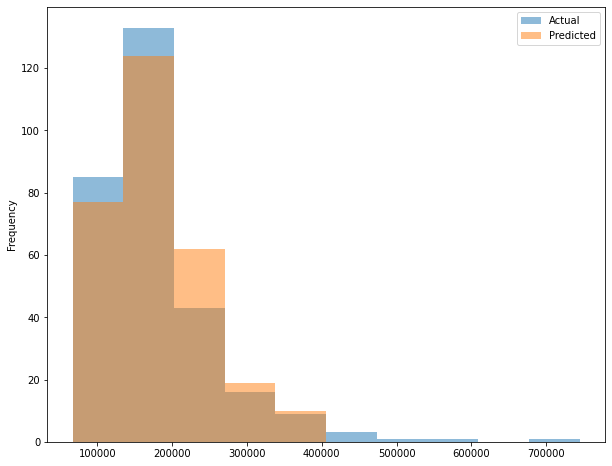

In [66]:
# pf = pd.DataFrame({'Actual': inv_boxcox1p(y_test, lmbda).apply(np.expm1), 'Predicted': np.floor(np.expm1(inv_boxcox1p(y_pred, lmbda)))})
pf = pd.DataFrame({'Actual': y_test.apply(np.expm1), 'Predicted': np.floor(np.expm1(y_pred5))})
pf.plot(kind='hist', figsize=(10, 8), alpha=.5)

In [5]:
pf = pd.DataFrame({'Actual': inv_boxcox1p(y_test, lmbda).apply(np.expm1), 'Predicted': np.floor(np.expm1(inv_boxcox1p(y_pred, lmbda)))})
xf = df.join(pf[['Actual', 'Predicted']]).assign(Delta=lambda xs: xs.Actual.sub(xs.Predicted))

keys = ['MSZoning']
xmap = xf.groupby(keys)[['Delta']].mean().reset_index()
xf = xf.drop(columns='Delta').merge(xmap, how='inner', on=keys)

xf['Predicted2'] = xf.Predicted.add(xf.Delta).round(0)
xf[['Actual', 'Predicted']].plot(kind='hist',  figsize=(10, 8), alpha=.5)

xf[['Actual', 'Predicted2']].plot(kind='hist',  figsize=(10, 8), alpha=.5)
round(rmse(xf.Actual, xf.Predicted2), 0)

/var/folders/6y/1n9l1vl92m967mnxhq5x56_w0000gn/T/ipykernel_79319/3234663973.py:1: RuntimeWarning: overflow encountered in expm1
  pf = pd.DataFrame({'Actual': inv_boxcox1p(y_test, lmbda).apply(np.expm1), 'Predicted': np.floor(np.expm1(inv_boxcox1p(y_pred, lmbda)))})


ValueError: autodetected range of [inf, inf] is not finite

1851.316438356078


13184.0

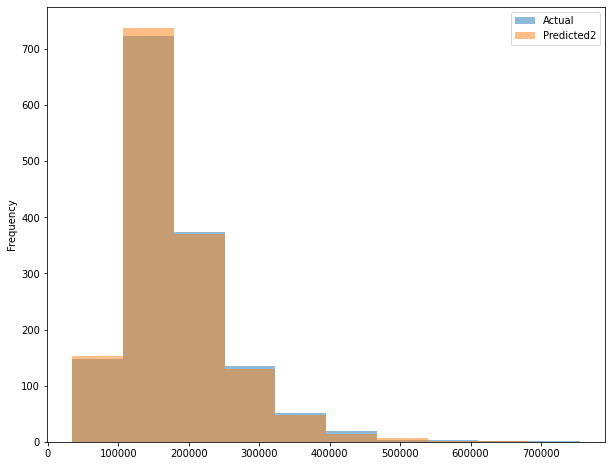

In [ ]:
pf = pd.DataFrame({'Actual': inv_boxcox1p(y_test, lmbda).apply(np.expm1), 'Predicted': np.floor(np.expm1(inv_boxcox1p(y_pred, lmbda)))})
coeff = pf.assign(Diff=lambda xs: xs.Actual.sub(xs.Predicted)).Diff.mean()
print(coeff)
pf = pf.assign(Predicted2=lambda xs: xs.Predicted.sub(coeff))
pf[['Actual', 'Predicted2']].plot(kind='hist', figsize=(10, 8), alpha=.5)
round(rmse(pf.Actual, pf.Predicted2), 0)

In [ ]:
len(set(ff[feature_cols].columns))

31

In [136]:

####################################
# Make final predictions
feature_cols

Index(['OverallQual', 'YearsOld', 'TotalSqf', 'LotArea', 'XX1', 'XX3',
       'QualSquared', 'CentralAir', 'MSZoning_C (all)', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'ExterCond_Ex',
       'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA',
       'Alley_Grvl', 'Alley_Pave', 'Electrical_FuseA', 'Electrical_FuseF',
       'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr',
       'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd',
       'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd',
       'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco',
       'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing',
       'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn',
       'Exterior2nd_BrkFace', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard',
       'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd'

In [160]:
for c in X_train.columns:
    if c not in ff:
        print(c)
        ff[c] = 0

Utilities_NoSeWa
Condition2_RRAe
Condition2_RRAn
Condition2_RRNn
HouseStyle_2.5Fin
RoofMatl_ClyTile
RoofMatl_Membran
RoofMatl_Metal
RoofMatl_Roll
Exterior1st_ImStucc
Exterior1st_Stone
Exterior2nd_AsphShn
Exterior2nd_Other
Heating_Floor
Heating_OthW
Electrical_Mix
GarageQual_Ex
PoolQC_Fa
MiscFeature_TenC


In [165]:
# set(X_train.columns) - set(ff.columns)
set(ff.columns) - set(X_train.columns)

{'Exterior2nd_CBlock'}

In [168]:

tf = pd.read_csv(f'{path}test.csv')
features = tf.drop(columns=['Id']).columns.to_list()
ff = process_data(df=tf, features=features)
feature_cols = ff.columns

for c in feature_cols:
    if c not in ff.columns:
        ff[c] = 0
ff = ff[feature_cols]

for c in X_train.columns:
    if c not in ff:
        print(c)
        ff[c] = 0

# Fill any all NAN columns with zeros
xs = ff.isnull().all()
for c in xs[xs == True].index:
    ff[c] = 0
    
ff = ff.drop(columns='Exterior2nd_CBlock')

#X = KNNImputer(missing_values=np.nan, n_neighbors=4).fit_transform(ff)
#X = RobustScaler().fit_transform(X)
#X = KNNImputer(missing_values=np.nan, n_neighbors=2).fit_transform(ff)
#X = StandardScaler().fit_transform(X)
# final_y_pred = model_xgb.predict(X)

#y_pred1 = model_xgb.predict(X)
#y_pred2 = model_ridge.predict(X)
#y_pred3 = model_lasso.predict(X)
#y_pred4 = model_rf.predict(X)
#y_pred5 = model_tf.predict(X).flatten()
#y_pred6 = model_srv.predict(X)
#final_y_pred = (.4 * y_pred1) + (.5 * y_pred5) + (.1 * y_pred3)
final_y_pred = model.predict(preprocess.fit_transform(ff))

tf['SalePrice'] = final_y_pred
# tf['SalePrice'] = np.floor(np.expm1(inv_boxcox1p(tf['SalePrice'], lmbda)))
tf['SalePrice'] = np.floor(np.expm1(tf['SalePrice']))

tf.SalePrice = tf.SalePrice.astype(np.int64)

# Add adjustment factor
#if 'Delta' in tf.columns:
#    tf.drop(columns='Delta')
#tf = tf.merge(xmap, how='left', on=keys)
#tf['SalePrice'] = tf.SalePrice.sub(tf.Delta.fillna(0)).round(0)

tf[['Id', 'SalePrice']].to_csv(f'{path}submission.csv', index=False)
!pwd

Utilities_NoSeWa
Condition2_RRAe
Condition2_RRAn
Condition2_RRNn
HouseStyle_2.5Fin
RoofMatl_ClyTile
RoofMatl_Membran
RoofMatl_Metal
RoofMatl_Roll
Exterior1st_ImStucc
Exterior1st_Stone
Exterior2nd_AsphShn
Exterior2nd_Other
Heating_Floor
Heating_OthW
Electrical_Mix
GarageQual_Ex
PoolQC_Fa
MiscFeature_TenC
/Users/jking/kaggle/house-prices-advanced-regression-techniques


In [169]:
path = '/Users/jking/kaggle/house-prices-advanced-regression-techniques/'
os.chdir(path)
!/Users/jking/opt/anaconda3/bin/kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m 'XGB / TF / Lasso 40 / 50 / 10'

100%|██████████████████████████████████████| 17.1k/17.1k [00:00<00:00, 24.0kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

In [ ]:
path = '/Users/jking/kaggle/house-prices-advanced-regression-techniques/'
df = pd.read_csv(f'{path}train.csv')
tf = pd.read_csv(f'{path}test.csv')

df = df[df.MSZoning == 'RL']
print(df.shape[0], tf.shape[0])

1151 1459


In [ ]:
pd.DataFrame(data={'Train': df.MSZoning.value_counts(), 'Test':  tf.MSZoning.value_counts()})

,Train,Test
C (all),NaN,15
FV,NaN,74
RH,NaN,10
RL,1151.0,1114
RM,NaN,242


In [ ]:
df.SalePrice.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [ ]:
high_corr = df.corr()['SalePrice'].abs()
high_corr[(high_corr.index != 'SalePrice') & (high_corr > .5)].index.to_list()

/var/folders/6y/1n9l1vl92m967mnxhq5x56_w0000gn/T/ipykernel_46327/573669939.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  high_corr = df.corr()['SalePrice'].abs()


['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea']

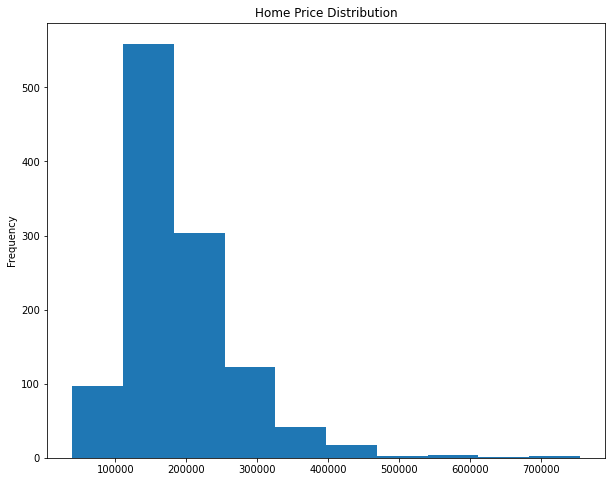

In [ ]:
_ = df.SalePrice.plot(kind='hist', figsize=(10, 8), title='Home Price Distribution')

<Axes: >

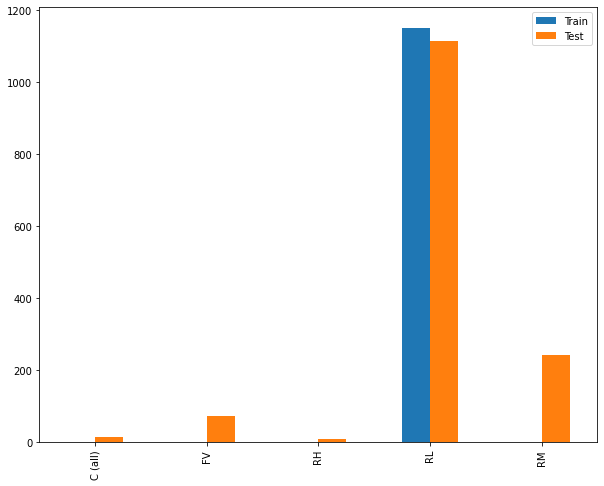

In [ ]:
pd.DataFrame(data={'Train': df.MSZoning.value_counts(), 'Test':  tf.MSZoning.value_counts()}).plot(kind='bar', figsize=(10, 8))

<Axes: title={'center': 'Home Counts by Zone'}>

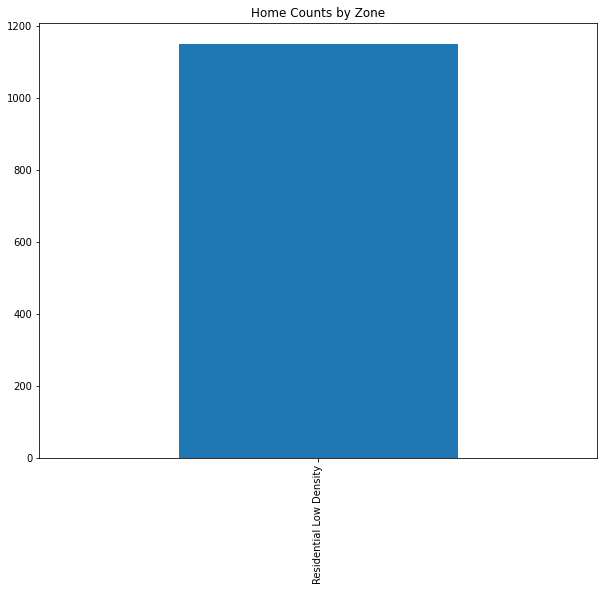

In [ ]:
zonining_map = {'A': 'Agriculture', 
                'C (all)': 'Comercial', 
                'FV': 'Floating Village Residential', 
                'I': 'Industrial', 
                'RH': 'Residential High Density', 
                'RL': 'Residential Low Density', 
                'RP': 'Residential Low Density Park', 
                'RM': 'Residential Medium Density'}
df.MSZoning.map(zonining_map).value_counts().plot(kind='bar', figsize=(10, 8), title='Home Counts by Zone')

<Axes: title={'center': 'Mean Sale price by Zone'}, xlabel='MSZoning'>

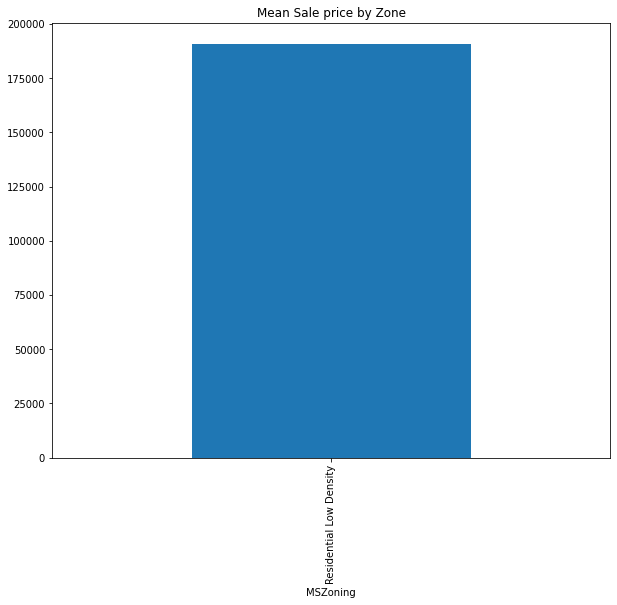

In [ ]:
df.groupby(df.MSZoning.map(zonining_map)).SalePrice.mean().sort_values(ascending=False).plot(kind='bar', figsize=(10, 8), title='Mean Sale price by Zone')

In [ ]:
# RH is very good .02
# FV is hard to predict, lower feature dimensionality?
# RL is the .11 lower bound
# RM is hard .147
# C (all) .47
# df = df[df.MSZoning == 'RL']

In [ ]:
# df[df.SalePrice >= df.SalePrice.max()].T

log_transform = True
if log_transform:
    df['SalePrice'] = np.log1p(df.SalePrice)
else:
    df = df[df.SalePrice <= 500000]  # Remove the outlier values
    _ = df.SalePrice.plot(kind='hist', figsize=(10, 8), title='Home Price Distribution')

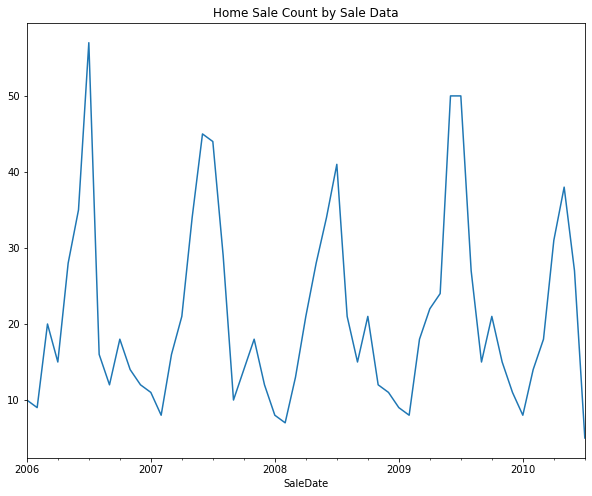

In [ ]:
# Add derived features
df['HasPool'] = df['PoolQC'].apply(lambda x: 1 if pd.isnull(x) else 0)
df['HasFireplace'] = df['FireplaceQu'].apply(lambda x: 1 if pd.isnull(x) else 0)

df['YearMonth'] = (df['YrSold'].astype(str) + df['MoSold'].astype(str).str.zfill(2)).astype(int)
df['SaleDate'] = pd.to_datetime(df.YearMonth.astype(str) + '01')
# How old was the house when it was sold?  Add indicator specifically for new builds $$$
df['YearsOldSale'] = df['YrSold'] - df['YearBuilt']
df['NewBuild'] = 0
df.loc[df.YearsOldSale == 0, 'NewBuild'] = 1
df.sort_values('SaleDate', inplace=True)

ax = df.groupby('SaleDate').size().plot(figsize=(10, 8), title='Home Sale Count by Sale Data')
# ax = df.groupby('SaleDate').SalePrice.sum().plot(figsize=(10, 8), title='Home Sale Count by Sale Data')

In [ ]:
df.groupby('SaleDate').size()

SaleDate
2006-01-01    10
2006-02-01     9
2006-03-01    20
2006-04-01    15
2006-05-01    28
2006-06-01    35
2006-07-01    57
2006-08-01    16
2006-09-01    12
2006-10-01    18
2006-11-01    14
2006-12-01    12
2007-01-01    11
2007-02-01     8
2007-03-01    16
2007-04-01    21
2007-05-01    34
2007-06-01    45
2007-07-01    44
2007-08-01    29
2007-09-01    10
2007-10-01    14
2007-11-01    18
2007-12-01    12
2008-01-01     8
2008-02-01     7
2008-03-01    13
2008-04-01    21
2008-05-01    28
2008-06-01    34
2008-07-01    41
2008-08-01    21
2008-09-01    15
2008-10-01    21
2008-11-01    12
2008-12-01    11
2009-01-01     9
2009-02-01     8
2009-03-01    18
2009-04-01    22
2009-05-01    24
2009-06-01    50
2009-07-01    50
2009-08-01    27
2009-09-01    15
2009-10-01    21
2009-11-01    15
2009-12-01    11
2010-01-01     8
2010-02-01    14
2010-03-01    18
2010-04-01    31
2010-05-01    38
2010-06-01    27
2010-07-01     5
dtype: int64

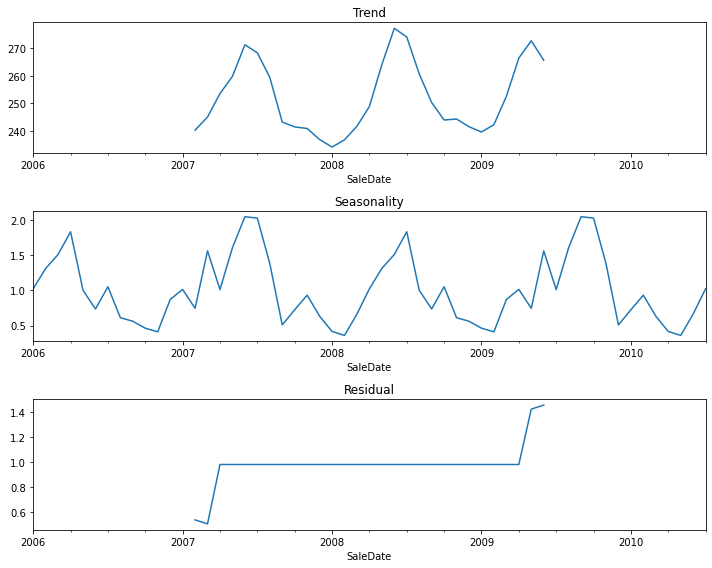

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# res = seasonal_decompose(df.groupby('SaleDate').size(), model='multiplicable', period=int(df.SaleDate.nunique()/2))
res = seasonal_decompose(df.groupby('SaleDate').SalePrice.sum(), model='multiplicable', period=int(df.SaleDate.nunique()/2))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 8))
res.trend.plot(ax=ax1, title='Trend')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.resid.plot(ax=ax3, title='Residual')
plt.tight_layout()

# Add TS decomp features
df = df.merge(res.seasonal, how='left', left_on='SaleDate', right_index=True)
df = df.merge(res.trend, how='left', left_on='SaleDate', right_index=True)
df = df.merge(res.resid, how='left', left_on='SaleDate', right_index=True)

# Add derived feature
df['QualSeason'] = df[['OverallQual', 'seasonal']].sum(axis=1)

In [ ]:

df.assign(SQ=lambda x: x.seasonal + x.OverallQual)[['trend', 'seasonal', 'resid', 'SQ', 'OverallQual', 'SalePrice']].corr()['SalePrice']

trend         -0.031361
seasonal      -0.022619
resid         -0.006412
SQ             0.792088
OverallQual    0.837555
SalePrice      1.000000
Name: SalePrice, dtype: float64

In [ ]:
df.assign(SQ=lambda x: x.seasonal + x.OverallQual)[['OverallQual', 'SQ']].corr()

,OverallQual,SQ
OverallQual,1.000000,0.935931
SQ,0.935931,1.000000


<Axes: title={'center': 'Top 20 features % NULL'}>

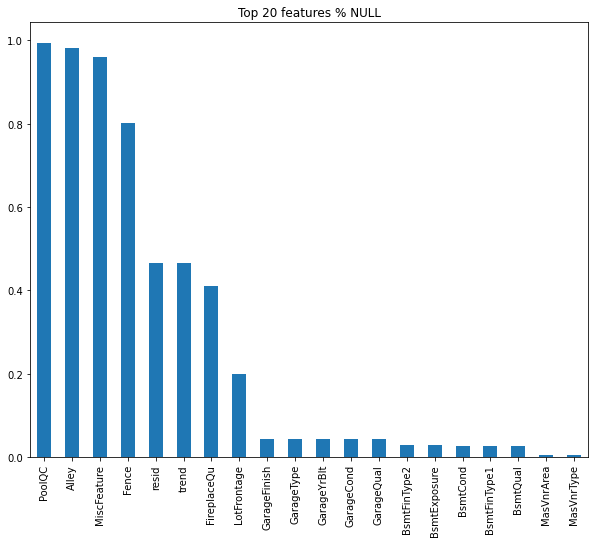

In [ ]:
df.isnull().sum().div(df.shape[0]).sort_values(ascending=False).head(20).plot(kind='bar', figsize=(10, 8), title='Top 20 features % NULL')

In [ ]:
# Remove features with great 80% NULL values, garbage will be imputed
high_pct_null = df.columns[df.isnull().sum().div(df.shape[0]) > .45]
print(high_pct_null)
df.drop(columns=high_pct_null, inplace=True)

# drop the same high percent NULL columns from the out of sample data
# tf.drop(columns=high_pct_null, inplace=True)

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'trend', 'resid'], dtype='object')


In [ ]:
# Only pairplot series where data type is not object or bool
# df.select_dtypes(exclude=['object', 'bool'])
# sns.pairplot(df.select_dtypes(exclude=['object', 'bool']))

In [ ]:
def adjust_overall_quality_for_outliers(df, y_train, contamination=.05):  # Was .05 .001 for just training set
    if df.shape[0] >= 25:
        df['Outlier'] = df.groupby('OverallQual').SalePrice.transform(lambda x: IsolationForest(
            contamination=contamination).fit(X=x.to_frame()).predict(x.to_frame()))
    else:
        # df['Outlier'] = 1
        df['Outlier'] = IsolationForest(contamination=.1).fit(X=df[['SalePrice']]).predict(df[['SalePrice']])
        
    df[['OverallQual', 'SalePrice']].plot(kind='scatter', x='OverallQual', y='SalePrice', alpha=.7)
    outliers = df[df.Outlier == -1]
    df.drop(columns=['Outlier'], inplace=True)
    # TODO: conert to stacked plot
    for _, row in outliers.iterrows():
        x = row['OverallQual']
        y = row['SalePrice']
        plt.scatter(x=x, y=y, color='red')
        
    # Replace the outlier overall quality value with the closest value from similar sale price homes
    avg_prc_by_qual = df.groupby('OverallQual').SalePrice.median()
    xs = df.loc[outliers.index, ['OverallQual', 'SalePrice']].apply(lambda x: (x.SalePrice < avg_prc_by_qual), axis=1)
    xs = xs.unstack().swaplevel().reset_index().groupby('level_0').apply(lambda xs: xs[xs[0] == True].OverallQual.min())
    df.loc[outliers.index, 'OverallQual'] = xs

    # avg_prc_by_qual = df.groupby('OverallQual').SalePrice.median()
    # xs = df.loc[outliers.index, ['OverallQual', 'SalePrice']].apply(lambda x: (x.SalePrice <= avg_prc_by_qual), axis=1)
    # xs = xs.unstack().swaplevel().reset_index().groupby('level_0').apply(lambda xs: xs[xs[0] == True].OverallQual.min())
    # df.rename(columns={'OverallQual': 'OverallQualOrig'}, inplace=True)
    # df.loc[outliers.index, 'OverallQual'] = xs
    # df.OverallQual.fillna(df.OverallQualOrig, inplace=True)
    
    df[['OverallQual', 'SalePrice']].plot(kind='scatter', x='OverallQual', y='SalePrice', alpha=.7)
    df = df.drop(columns=['SalePrice'])
    # df = df.drop(columns=['SalePrice', 'OverallQualOrig'])
    # return df[~df.index.isin(outliers.index)], y_train[~y_train.index.isin(outliers.index)]
    return df, y_train

In [ ]:
if df.shape[0] >= 25:
    df['Outlier'] = df.groupby('OverallQual').SalePrice.transform(lambda x: IsolationForest(contamination=.05).fit(X=x.to_frame()).predict(x.to_frame()))
else:
    # df['Outlier'] = 1
    df['Outlier'] = IsolationForest(contamination=.1).fit(X=df[['SalePrice']]).predict(df[['SalePrice']])

In [ ]:
# df['QualSalePriceXX'] = df[['OverallQual', 'SalePrice']].mean(axis=1)
# df['QualSalePriceXX'] = df['SalePrice'] - df.OverallQual
df['QualSalePriceXX'] = df['SalePrice'] * df.OverallQual

cols= ['QualSalePriceXX']
model_if = IsolationForest(contamination=.005).fit(X=df[cols])
of = model_if.predict(df[cols])
df['OverallQualOL'] = of

outliers = df[df['OverallQualOL'] == -1][['OverallQual', 'SalePrice']]
df.drop(columns=['QualSalePriceXX', 'OverallQualOL'], inplace=True)
outliers

/Users/jking/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,OverallQual,SalePrice
1169,10,13.345509
691,10,13.534474
533,1,10.579005
1182,10,13.521141
1100,2,11.002117
375,1,11.018646


In [ ]:
df_orig = df.copy()
index = []
idx = df[df.OverallQual == 10].SalePrice.sort_values().head(2).index
df.loc[idx, 'SalePrice'] = df[df.OverallQual == 10].SalePrice.median()
index += idx.to_list()

idx = df[df.OverallQual == 8].SalePrice.sort_values().head(1).index
idx = idx.append(df[df.OverallQual == 8].SalePrice.sort_values(ascending=False).head(1).index)
df.loc[idx, 'SalePrice'] = df[df.OverallQual == 8].SalePrice.median()
index += idx.to_list()

idx = df[df.OverallQual == 7].SalePrice.sort_values().head(1).index
df.loc[idx, 'SalePrice'] = df[df.OverallQual == 7].SalePrice.median()
index += idx.to_list()

idx = df[df.OverallQual == 6].SalePrice.sort_values().head(2).index
df.loc[idx, 'SalePrice'] = df[df.OverallQual == 6].SalePrice.median()
index += idx.to_list()

idx = idx.append(df[df.OverallQual == 4].SalePrice.sort_values(ascending=False).head(1).index)
df.loc[idx, 'SalePrice'] = df[df.OverallQual == 4].SalePrice.median()
index += idx.to_list()

idx = df[df.OverallQual == 3].SalePrice.sort_values().head(1).index
df.loc[idx, 'SalePrice'] = df[df.OverallQual == 3].SalePrice.median()
index += idx.to_list()

idx = df[df.OverallQual == 2].SalePrice.sort_values().head(1).index
df.loc[idx, 'SalePrice'] = df[df.OverallQual == 2].SalePrice.median()
index += idx.to_list()

idx = df[df.OverallQual == 1].SalePrice.sort_values(ascending=False).head(1).index
df.loc[idx, 'SalePrice'] = df[df.OverallQual == 1].SalePrice.median()
index += idx.to_list()

outliers = df.loc[index, ['OverallQual', 'SalePrice']]

In [ ]:
outliers

,OverallQual,SalePrice
1298,10,12.991756
523,10,12.991756
1324,8,12.522527
769,8,12.522527
632,7,12.230770
155,6,11.652696
1376,6,11.652696
155,6,11.652696
1376,6,11.652696
457,4,11.652696


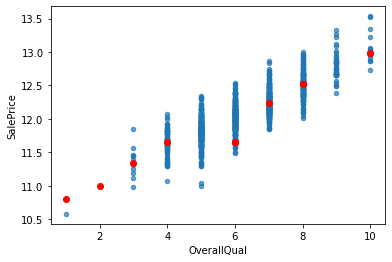

In [ ]:
df[['OverallQual', 'SalePrice']].plot(kind='scatter', x='OverallQual', y='SalePrice', alpha=.7)
# outliers = df[df.Outlier == -1]
# df.drop(columns=['Outlier'], inplace=True)
for idx, row in outliers.iterrows():
    x = row['OverallQual']
    y = row['SalePrice']
    plt.scatter(x=x, y=y, color='red')

In [ ]:
# Replace the outlier overall quality value with the closest value from similar sale price homes
avg_prc_by_qual = df.groupby('OverallQual').SalePrice.median()
xs = df.loc[outliers.index, ['OverallQual', 'SalePrice']].apply(lambda x: (x.SalePrice < avg_prc_by_qual), axis=1)
xs = xs.unstack().swaplevel().reset_index().groupby('level_0').apply(lambda xs: xs[xs[0] == True].OverallQual.min())
df.loc[outliers.index, 'OverallQual'] = xs

In [ ]:
# A litte too trivial of a change
# df.loc[outliers.index, 'OverallQual'] = df.OverallQual.median()
# df = df[~df.index.isin(outliers.index)]

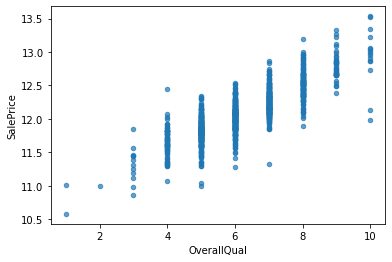

In [ ]:
_ = df_orig[['OverallQual', 'SalePrice']].plot(kind='scatter', x='OverallQual', y='SalePrice', alpha=.7)

In [ ]:
df['XX1'] = df[['OverallQual', 'GarageCars']].mean(axis=1)
df['XX2'] = df[['OverallQual', 'GarageCars', 'GrLivArea']].mean(axis=1)
df['XX3'] = df[['OverallQual', 'YearBuilt', 'YearRemodAdd']].mean(axis=1)
#
tf['XX1'] = tf[['OverallQual', 'GarageCars']].mean(axis=1)
tf['XX2'] = tf[['OverallQual', 'GarageCars', 'GrLivArea']].mean(axis=1)
tf['XX3'] = tf[['OverallQual', 'YearBuilt', 'YearRemodAdd']].mean(axis=1)

<Axes: ylabel='Frequency'>

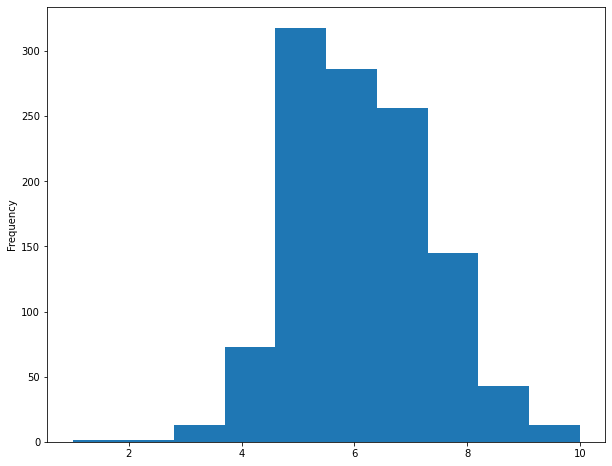

In [ ]:
# GarageCars
df['OverallQual'].plot(kind='hist', figsize=(10,8))

In [ ]:
df.isnull().sum().div(df.shape[0])

Id             0.000000
MSSubClass     0.000000
MSZoning       0.000000
LotFrontage    0.198957
LotArea        0.000000
                 ...   
QualSeason     0.000000
Outlier        0.000000
XX1            0.000000
XX2            0.000000
XX3            0.000000
Length: 89, dtype: float64

<Axes: title={'center': 'Top 20 features % NULL'}>

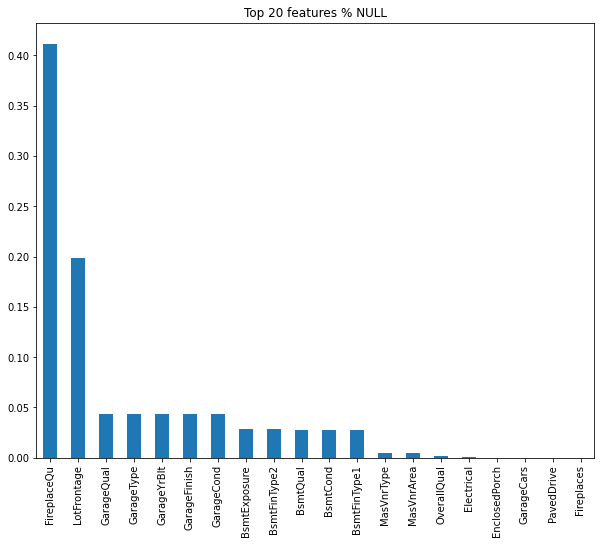

In [ ]:
# df.isnull().sum().sort_values(ascending=False).head(20).plot(kind='bar', figsize=(10, 8), title='Top 20 features with NULLs')
# Kill anything with greater than 80% NULL obs?
df.isnull().sum().div(df.shape[0]).sort_values(ascending=False).head(20).plot(kind='bar', figsize=(10, 8), title='Top 20 features % NULL')

In [ ]:
X = df.drop(columns=['Id', 'SaleDate', 'SalePrice', 'MSZoning', 'BsmtQual'])
y = df['SalePrice']
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,YearMonth,SaleDate,YearsOldSale,NewBuild,seasonal,QualSeason,Outlier,XX1,XX2,XX3
141,142,20,RL,78.0,11645,Pave,Reg,Lvl,AllPub,Inside,...,200601,2006-01-01,1,0,1.022108,8.022108,1,4.5,581.000000,1339.000000
810,811,20,RL,78.0,10140,Pave,Reg,Lvl,AllPub,Inside,...,200601,2006-01-01,32,0,1.022108,7.022108,1,4.0,439.000000,1326.333333
302,303,20,RL,118.0,13704,Pave,IR1,Lvl,AllPub,Corner,...,200601,2006-01-01,5,0,1.022108,8.022108,1,5.0,517.000000,1336.666667
996,997,20,RL,NaN,10659,Pave,IR1,Lvl,AllPub,Inside,...,200601,2006-01-01,45,0,1.022108,6.022108,1,3.0,352.000000,1309.000000
169,170,20,RL,NaN,16669,Pave,IR1,Lvl,AllPub,Corner,...,200601,2006-01-01,25,0,1.022108,9.022108,1,5.0,572.333333,1323.333333


In [ ]:
def pre_process(X):
    for c, t in X.dtypes.iteritems():
        if is_string_dtype(t):
            x = 1
            X = X.merge(pd.get_dummies(X[c], prefix=c), left_index=True, right_index=True)
            X.drop(columns=c, inplace=True)

    # Replace NULL values with the median
    idx = X.index
    cols = X.columns
    
    # X = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(X)
    X = KNNImputer(missing_values=np.nan, n_neighbors=3).fit_transform(X)
    X = RobustScaler().fit_transform(X)
    # X = StandardScaler().fit_transform(X)
    
    X = pd.DataFrame(data=X, columns=cols, index=idx)
    print(X.isnull().sum().sum())
    
    high_corr = df.corr()['SalePrice'].abs()
    features = high_corr[(high_corr.index != 'SalePrice') & (high_corr > .25)].index.to_list()
    features = X.columns
    return X[features]

X = pre_process(X=X)

/var/folders/6y/1n9l1vl92m967mnxhq5x56_w0000gn/T/ipykernel_46327/3484917260.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for c, t in X.dtypes.iteritems():


0


/var/folders/6y/1n9l1vl92m967mnxhq5x56_w0000gn/T/ipykernel_46327/3484917260.py:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  high_corr = df.corr()['SalePrice'].abs()


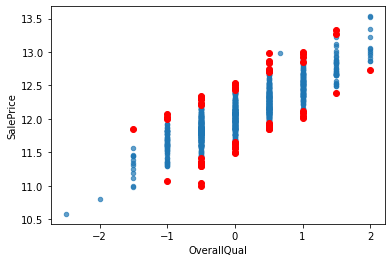

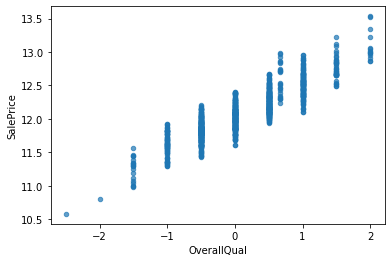

In [ ]:
X, y = adjust_overall_quality_for_outliers(df=pd.concat([X, y], axis=1), y_train=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [ ]:
# X_train, y_train = adjust_overall_quality_for_outliers(df=pd.concat([X_train, y_train], axis=1), y_train=y_train)

In [ ]:
print(df[['OverallQual', 'SalePrice']].corr())
print(pd.concat([X_train, y_train], axis=1)[['OverallQual', 'SalePrice']].corr())

             OverallQual  SalePrice
OverallQual     1.000000   0.852984
SalePrice       0.852984   1.000000
             OverallQual  SalePrice
OverallQual     1.000000   0.884645
SalePrice       0.884645   1.000000


In [ ]:
print(len(df.columns), len(X_train.columns))

89 267


In [ ]:
# sorted(X_train.columns)
# type(X_train)
print(df.loc[X_train.index].corr()['SalePrice'].sort_values(ascending=False).head())
pd.concat([X_train, y_train], axis=1).corr()['SalePrice'].sort_values(ascending=False).head(10)

SalePrice      1.000000
XX1            0.854977
OverallQual    0.852079
QualSeason     0.802843
GrLivArea      0.756546
Name: SalePrice, dtype: float64


/var/folders/6y/1n9l1vl92m967mnxhq5x56_w0000gn/T/ipykernel_46327/2429804676.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.loc[X_train.index].corr()['SalePrice'].sort_values(ascending=False).head())


SalePrice      1.000000
OverallQual    0.884645
XX1            0.854977
QualSeason     0.802843
GrLivArea      0.756546
XX2            0.719138
GarageCars     0.685941
GarageArea     0.661673
TotalBsmtSF    0.618894
FullBath       0.612073
Name: SalePrice, dtype: float64

In [ ]:
final_X = tf.drop(columns=['Id'])
final_X = pre_process(X=final_X)

missing = list(set(X_train.columns) - set(final_X.columns))

for c in missing:
    final_X[c] = 0 
print(missing)
final_X.drop(columns=missing, inplace=True)
X_train.drop(columns=missing, inplace=True)
X_test.drop(columns=missing, inplace=True)

/var/folders/6y/1n9l1vl92m967mnxhq5x56_w0000gn/T/ipykernel_46327/3484917260.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for c, t in X.dtypes.iteritems():


0
['QualSeason', 'Exterior1st_Stone', 'YearMonth', 'RoofMatl_Membran', 'HasFireplace', 'RoofMatl_ClyTile', 'YearsOldSale', 'NewBuild', 'Exterior1st_ImStucc', 'RoofMatl_Roll', 'Heating_Floor', 'Utilities_NoSeWa', 'HouseStyle_2.5Fin', 'Condition2_RRAe', 'GarageQual_Ex', 'HasPool', 'Exterior2nd_Other', 'Condition2_RRAn', 'RoofMatl_Metal', 'seasonal']


/var/folders/6y/1n9l1vl92m967mnxhq5x56_w0000gn/T/ipykernel_46327/3484917260.py:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  high_corr = df.corr()['SalePrice'].abs()


In [ ]:
def rmse(actual, y_pred, **kwargs) -> float:
    # return np.sqrt(mean_squared_log_error(actual, y_pred))
    # Use MSE since y is already in log space
    return np.sqrt(mean_squared_error(actual, y_pred))

def cv_rmse(model, X , Y, kf=10):
    # res = np.sqrt(-cross_val_score(model,X, Y, scoring="neg_mean_squared_error", cv=kf))
    # res = np.sqrt(-cross_val_score(model,X, Y, scoring=make_scorer(rmse, greater_is_better=False), cv=kf))
    res = np.sqrt(-cross_val_score(model,X, Y, scoring="mean_squared_error", cv=kf))
    return (res)

In [ ]:
model_rf = RandomForestRegressor(n_estimators=8000)
# model.fit(X_train, y_train)

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=8000,
                         # learning_rate=.001,  # Good
                         learning_rate=.05,
                         max_depth=3,
                         # min_child_weight=2,
                         # subsample=1,
                         colsample_bytree=1,
                         # objective='reg:squaredlogerror',
                         # colsample_bytree=0,
                         # max_delta_step=10,
                         # eval_metric=mean_squared_log_error)
                         # early_stopping_rounds=20, 
                         # eval_metric='rmsle')
                         eval_metric=rmse)

In [ ]:
model_dt = DecisionTreeRegressor()

In [ ]:
cv = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(estimator=model_xgb, X=X_train, y=y_train, cv=cv, scoring=make_scorer(rmse))
# scores = cv_rmse(model_dt, X_train, y_train)

In [ ]:
scores.mean(), scores.std()

(0.1150107451661849, 0.0076287788419436165)

In [ ]:
xs = X_train.isnull().any()
xs[xs==True]

df[df.OverallQual.isnull()]
X_train.OverallQual.fillna(X_train.OverallQual.mean(), inplace=True)

0.1860471860394917


<Axes: >

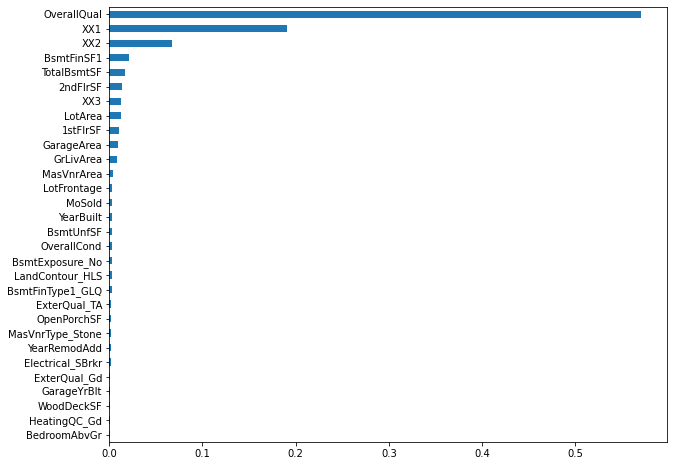

In [ ]:
model_dt.fit(X_train, y_train)
y_pred = model_dt.predict(X_test.fillna(0))
rmse(y_test, y_pred)
print(rmse(y_test, y_pred))
pd.Series(index=model_dt.feature_names_in_, data=model_dt.feature_importances_).sort_values(ascending=True).tail(30).plot(kind='barh', figsize=(10, 8))

In [ ]:
# model_xgb.fit(X_train, y_train,  
#              eval_set=[(X_train, y_train), (X_test, y_test)],  
#              verbose=True)
# X_train.drop(columns=['Outlier'], inplace=True)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
rmse(y_test, y_pred)

0.1066765386034972

<Axes: >

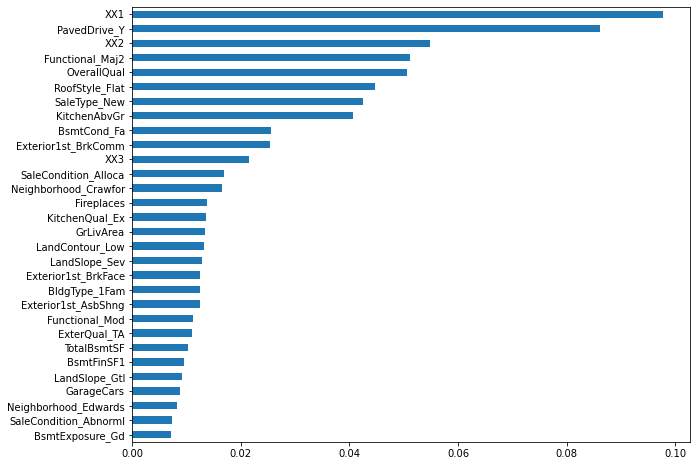

In [ ]:
# Plot feature importance for the generic XGB model
pd.Series(index=model_xgb.feature_names_in_, data=model_xgb.feature_importances_).sort_values(ascending=True).tail(30).plot(kind='barh', figsize=(10, 8))

In [ ]:
cv = KFold(n_splits=5, shuffle=True)

model_mlp = MLPRegressor(activation='relu', alpha=.05, learning_rate='adaptive', solver='adam')
model_svm = SVR()
model_lasso = Lasso()
model_adaboost = AdaBoostRegressor(n_estimators=5000, learning_rate=.05)

# estimators = [('dt', model_dt), ('rf', model_rf), ('xgb', model_xgb)]
estimators = [('rf', model_rf), ('mlp', model_mlp), ('svm', model_svm), ('lasso', model_lasso), ('ada', model_adaboost), ('xgb', model_xgb)]
# estimators = [('rf', model_rf), ('lasso', model_lasso), ('ada', model_adaboost), ('xgb', model_xgb)] # Was the best model
model = StackingRegressor(estimators=estimators, cv=cv)
model.fit(X_train, y_train)  # make this training only!

/Users/jking/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jking/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


StackingRegressor(cv=KFold(n_splits=5, random_state=RandomState(MT19937) at 0x28E506E40,
   shuffle=True),
                  estimators=[('rf', RandomForestRegressor(n_estimators=8000)),
                              ('mlp',
                               MLPRegressor(alpha=0.05,
                                            learning_rate='adaptive')),
                              ('svm', SVR()), ('lasso', Lasso()),
                              ('ada',
                               AdaBoostRegressor(learning_rate=0.05,
                                                 n_estimators=5000)),
                              ('xgb',
                               XGBRegressor(base_score=None, b...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=8000, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))])

In [ ]:
y_pred = model.predict(X_test.fillna(0))

In [ ]:
# Where the fuck did this NULL overall quality value come from?
X_test[X_test.OverallQual.isnull()]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
803,0.25,1.478261,1.036533,NaN,0.0,0.752941,0.422535,2.355556,-0.580271,0.0,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0


In [ ]:
# 0.138
# 0.1159 - Removal of large prices >= 500K
# 0.11241 - KNN Imputer
# np.sqrt(mean_squared_log_error(y_test, y_pred))
rmse(y_test, y_pred) # * coeff)

0.10666977684401341

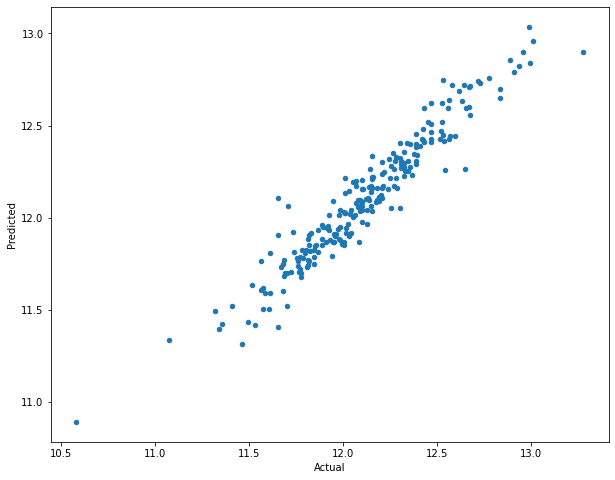

In [ ]:
pf = pd.DataFrame(data={'Actual': y_test, 'Predicted': y_pred})
pf['Delta'] = abs(pf.Actual - pf.Predicted)
ax = pf.plot(kind='scatter', x='Actual', y='Predicted', figsize=(10, 8))

In [ ]:
pf.sort_values('Delta', ascending=False).head(20).OverallQual.value_counts()

AttributeError: 'DataFrame' object has no attribute 'OverallQual'

In [ ]:
pf.sort_values('Delta', ascending=False).head(20).MSZoning.value_counts()

AttributeError: 'DataFrame' object has no attribute 'MSZoning'

In [ ]:
df[['NewBuild', 'SalePrice']].corr()
# sorted(df.columns)

,NewBuild,SalePrice
NewBuild,1.000000,0.227257
SalePrice,0.227257,1.000000


<Axes: ylabel='Frequency'>

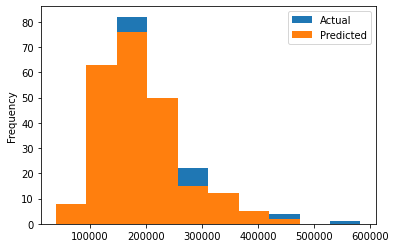

In [ ]:
pf.apply(np.exp)[['Actual', 'Predicted']].plot(kind='hist')

In [ ]:
y_train.shape, y_pred.shape

((920,), (231,))

<Axes: title={'center': 'Home Price Distribution'}, ylabel='Frequency'>

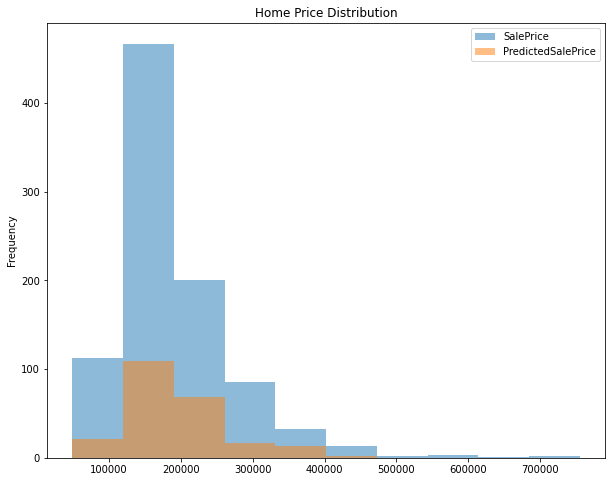

In [ ]:
pd.concat([y_train.apply(np.expm1), pd.DataFrame({'PredictedSalePrice': np.expm1(y_pred)})], axis=1).plot(
    kind='hist', figsize=(10, 8), title='Home Price Distribution', alpha=.5)

In [ ]:

# model_ols = sm.OLS(endog=pf.Actual, exog=sm.add_constant(pf.Predicted))
model_ols = sm.OLS(endog=pf.Actual, exog=pf.Predicted)
res =  model_ols.fit()
print(res.summary())
coeff = res.params.values[0]

rmse(y_test, model_xgb.predict(X_test) * coeff)

                                 OLS Regression Results                                
Dep. Variable:                 Actual   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.994e+06
Date:                Tue, 13 Jun 2023   Prob (F-statistic):                        0.00
Time:                        08:52:51   Log-Likelihood:                          190.14
No. Observations:                 231   AIC:                                     -378.3
Df Residuals:                     230   BIC:                                     -374.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

0.10637243055762617

In [ ]:
pd.DataFrame(index=X_train.columns, data={'Importance': model_xgb.feature_importances_}).sort_values('Importance', ascending=False).head(20)

,Importance
XX1,0.097775
PavedDrive_Y,0.086142
XX2,0.054833
Functional_Maj2,0.051218
OverallQual,0.050616
RoofStyle_Flat,0.044629
SaleType_New,0.042594
KitchenAbvGr,0.040717
BsmtCond_Fa,0.025630
Exterior1st_BrkComm,0.025383


In [ ]:
idx = pf.Delta.abs().sort_values(ascending=False).head(10).index
df.loc[idx].merge(pf.loc[idx, 'Predicted'], left_index=True, right_index=True)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleDate,YearsOldSale,NewBuild,seasonal,QualSeason,Outlier,XX1,XX2,XX3,Predicted
457,458,20,RL,NaN,53227,Pave,IR1,Low,AllPub,CulDSac,...,2008-03-01,54,0,0.663226,4.663226,-1,3.5,556.666667,1317.666667,12.108077
218,219,50,RL,NaN,15660,Pave,IR1,Lvl,AllPub,Corner,...,2008-05-01,69,0,1.310272,8.310272,1,4.5,654.333333,1317.333333,12.266697
803,804,60,RL,107.0,13891,Pave,Reg,Lvl,AllPub,Inside,...,2009-01-01,1,0,0.462935,9.462935,1,6.0,944.666667,1342.000000,12.897821
560,561,20,RL,NaN,11341,Pave,IR1,Lvl,AllPub,Inside,...,2010-05-01,53,0,0.359835,5.359835,1,3.5,466.333333,1319.333333,12.061846
533,534,20,RL,50.0,5000,Pave,Reg,Low,AllPub,Inside,...,2007-01-01,61,0,1.013266,2.013266,1,0.5,111.666667,1299.000000,10.891784
13,14,20,RL,91.0,10652,Pave,IR1,Lvl,AllPub,Inside,...,2007-08-01,1,0,1.380649,8.380649,1,5.0,501.333333,1340.000000,12.258807
1432,1433,30,RL,60.0,10800,Pave,Reg,Lvl,AllPub,Inside,...,2007-08-01,80,0,1.380649,5.380649,-1,2.5,324.333333,1312.666667,11.339221
1048,1049,20,RL,100.0,21750,Pave,Reg,Lvl,AllPub,Inside,...,2009-11-01,49,0,1.380649,6.380649,1,3.5,592.666667,1323.666667,11.904518
1059,1060,50,RL,NaN,11275,Pave,IR1,HLS,AllPub,Corner,...,2007-03-01,75,0,1.560215,7.560215,1,4.0,666.333333,1296.000000,12.054124
155,156,50,RL,60.0,9600,Pave,Reg,Lvl,AllPub,Corner,...,2008-04-01,84,0,1.022108,7.022108,-1,2.5,367.000000,1293.000000,11.405807


In [ ]:
df[df.Id == 524][['YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold', 'MSZoning']].T.head(20)

,523
YearBuilt,2007
YearRemodAdd,2008
YrSold,2007
MoSold,10
MSZoning,RL


In [ ]:
print(X_train.shape[1], final_X.shape[1])
missing_cols = set(final_X.columns) - set(X_train.columns) 
# print(missing_cols)
for c in missing_cols:
    print(c)
    # final_X[c] = 0
    del final_X[c]

247 247


In [ ]:
# final_y_pred = model_xgb.predict(final_X)
final_y_pred = model.predict(final_X)

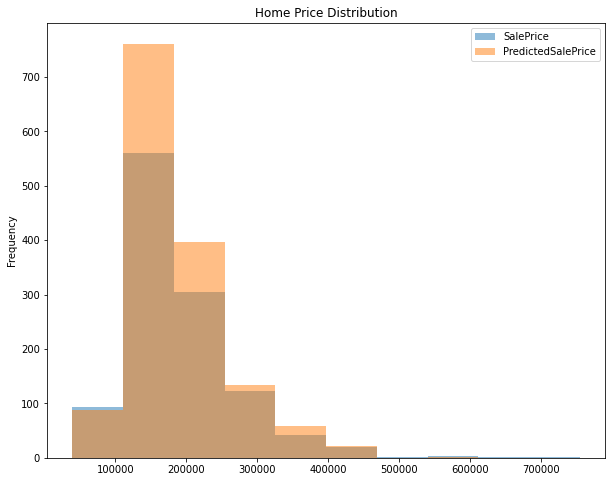

In [ ]:
if log_transform:
    pd.concat([df.SalePrice.apply(np.expm1), pd.DataFrame({'PredictedSalePrice': np.expm1(final_y_pred)*coeff})], axis=1).plot(
        kind='hist', figsize=(10, 8), title='Home Price Distribution', alpha=.5)
else:
    pd.concat([df.SalePrice, pd.DataFrame({'PredictedSalePrice': final_y_pred})], axis=1).plot(
        kind='hist', figsize=(10, 8), title='Home Price Distribution', alpha=.5)

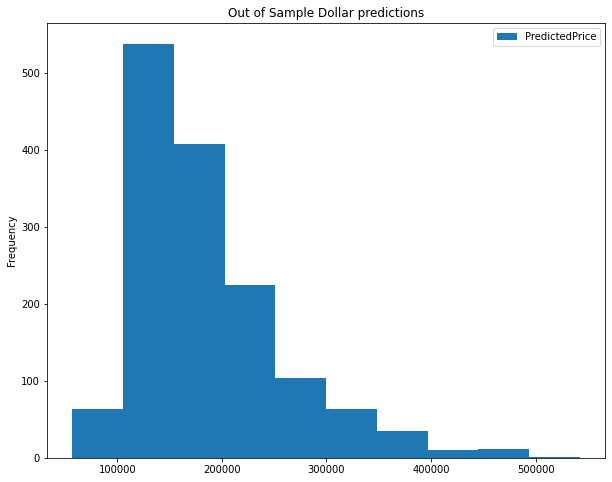

In [ ]:
if log_transform:
    _ = pd.DataFrame({'PredictedPrice': np.expm1(final_y_pred)}).plot(
        kind='hist', figsize=(10, 8), title='Out of Sample Dollar predictions')
else:
    _ = pd.DataFrame({'PredictedPrice': final_y_pred}).plot(
        kind='hist', figsize=(10, 8), title='Out of Sample Dollar predictions')

In [ ]:
tf['SalePrice'] = final_y_pred
if log_transform:
    tf['SalePrice'] = np.expm1(tf['SalePrice'])

tf.SalePrice = tf.SalePrice.astype(np.int64)
tf[['Id', 'SalePrice']].to_csv(f'{path}submission.csv', index=False)

In [ ]:
path = '/Users/jking/kaggle/house-prices-advanced-regression-techniques/'

In [ ]:
os.chdir(path)

In [ ]:
!pwd

/Users/jking/kaggle/house-prices-advanced-regression-techniques


In [ ]:
!/Users/jking/opt/anaconda3/bin/kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m 'Boosting Regression Model'

100%|██████████████████████████████████████| 17.1k/17.1k [00:00<00:00, 28.5kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques